# Main Script Airline Dataset

First all required packages are loaded.

Note, that only well known packages are used and all functions, methods or procedures applied are well described on the websited of the respective packages.

In [1]:
# import all required packages
import time
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
plt.style.use('ggplot')

import networkx as nx
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

import dgl
import dgl.nn as dglnn

import torch
import torch.nn as nn
import torch.nn.functional as F
from sage import SAGEConv

import tqdm

import sklearn.metrics
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

Using backend: pytorch


The normalization function for scaling the data within the range between 1 - 5 is defined below

In [2]:
# used for scaling non-ordinal data within the range of 1 - 5 
def normalize(x):
    return (x-x.min())/(x.max()-x.min()) * (5-1) + 1

The following function is the L2-normalization applied in the GraphSage model

In [3]:
# l2 normalization of GNN layer outputs after activation function
def norm(x):
    return F.normalize(x, p=2, dim=-1)

Norm = norm

## Load the, Inspect and Pre-Process the Training Data

In [4]:
df = pd.read_csv('DataFrame')
X = pd.read_csv('clean_data')

In [5]:
df['Type of Travel'].value_counts(normalize=True)

Business travel    0.689167
Personal Travel    0.310833
Name: Type of Travel, dtype: float64

In [6]:
X.drop(columns=['Unnamed: 0'],inplace=True)
X.Class = X.Class.apply(lambda x: 1 if x == 0 else(2 if x == 1 else 3))
X

Gender  Customer Type  Age  Type of Travel  Class  Flight Distance  \
0          1              0   69               0      1              964   
1          0              0   55               1      3              240   
2          1              0   51               1      3             2672   
3          0              1   27               1      1              495   
4          0              0   12               0      1              462   
...      ...            ...  ...             ...    ...              ...   
5995       1              0   49               0      1             1587   
5996       1              0   33               0      1              588   
5997       0              0   50               0      1             2358   
5998       0              0   35               0      1              672   
5999       0              0   32               0      3              397   

      Inflight wifi service  Departure/Arrival time convenient  \
0                         3                                  2   
1                         2                                  5   
2                         5                                  5   
3                         2                                  3   
4                         2                                  4   
...                     ...                                ...   
5995                      3                                  4   
5996                      2                                  5   
5997                      1                                  4   
5998                      2                                  3   
5999                      3                                  4   

      Ease of Online booking  Gate location  ...  Seat comfort  \
0                          3              3  ...             2   
1                          5              5  ...             2   
2                          5              5  ...             1   
3                          2              2  ...             3   
4                          2              3  ...             2   
...                      ...            ...  ...           ...   
5995                       3              4  ...             5   
5996                       2              3  ...             5   
5997                       1              5  ...             4   
5998                       2              2  ...             5   
5999                       3              1  ...             4   

      Inflight entertainment  On-board service  Leg room service  \
0                          5                 5                 3   
1                          1                 1                 2   
2                          4                 4                 4   
3                          3                 4                 4   
4                          2                 3                 4   
...                      ...               ...               ...   
5995                       4                 4                 3   
5996                       5                 5                 3   
5997                       4                 4                 5   
5998                       5                 1                 1   
5999                       4                 4                 2   

      Baggage handling  Checkin service  Inflight service  Cleanliness  \
0                    5                1                 5            3   
1                    3                2                 3            2   
2                    4                5                 4            3   
3                    3                4                 2            3   
4                    2                2                 1            2   
...                ...              ...               ...          ...   
5995                 5                3                 4            5   
5996                 5                5                 5            5   
5997                 4  

In [7]:
# Distribution of Gender in the data
X.Gender.value_counts(normalize=True)

1    0.507667
0    0.492333
Name: Gender, dtype: float64

<Figure size 2160x2160 with 0 Axes>

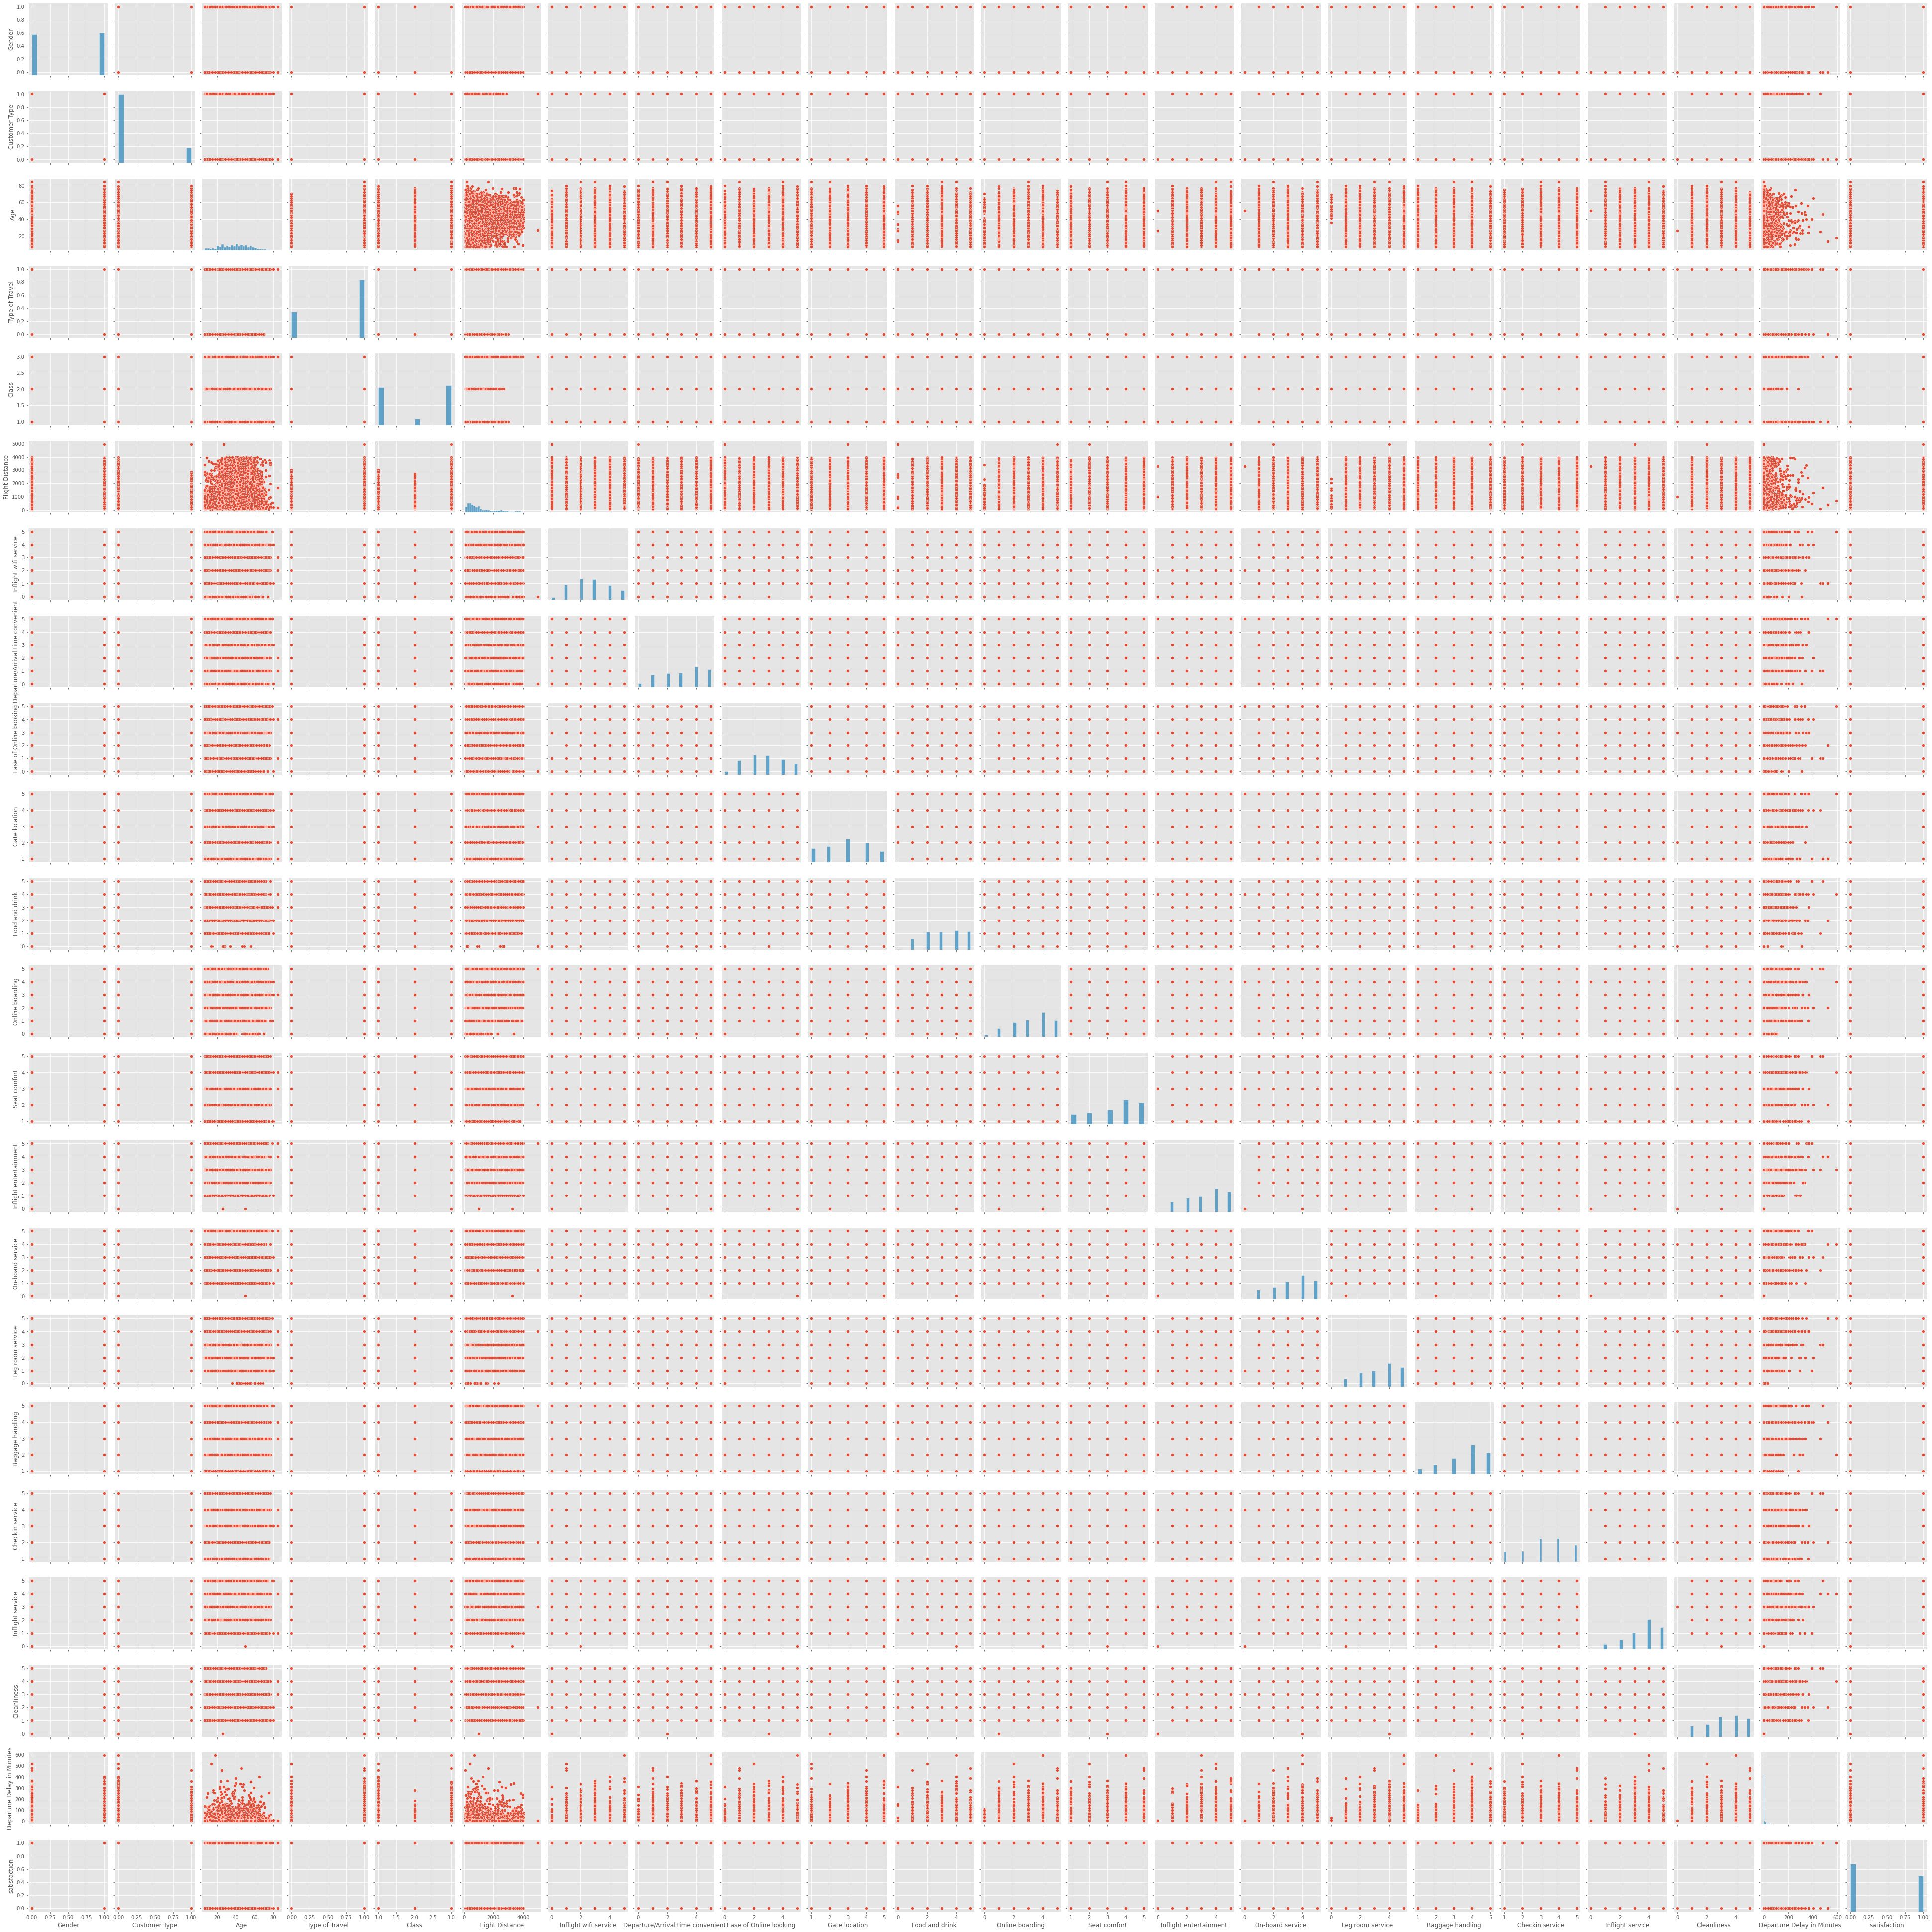

In [8]:
# Pairplot of ht entire dataset
plt.figure(figsize=(30,30))
sns.pairplot(X)
plt.show()

In [9]:
# Can be used to investigate the value counts for every category given the typ of travel
bus = (X['Type of Travel'] == 1)
pers = (X['Type of Travel'] == 0)
X[pers]['Gate location'].value_counts()

3    665
4    460
2    339
1    277
5    124
Name: Gate location, dtype: int64

In [10]:
X[bus]['satisfaction'].describe()

count    4135.000000
mean        0.578718
std         0.493824
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: satisfaction, dtype: float64

## Load the Graph Generated in The Data Script

In [11]:
A = np.loadtxt('adjacency_matrix.csv',delimiter=',')

In [12]:
np.diag(A).sum()

0.0

In [13]:
G = nx.from_numpy_matrix(A)

In [14]:
nx.is_connected(G)

True

## Dummy Code and Normalize the Data

In [16]:
features = pd.Series(X.satisfaction) # separate label from features
x_var = X.drop(columns=['satisfaction'])
x_wd = pd.get_dummies(data=x_var,columns=['Customer Type','Type of Travel','Gender'])
x_wd[['Age','Departure Delay in Minutes','Flight Distance']] = normalize(x_wd[['Age','Departure Delay in Minutes','Flight Distance']])

## Load and Pre-Process the Test Data in the exact same way as the Training Data

In [17]:
# Load Test Data
df_test = pd.read_csv('test.csv',sep=',')
df_test = df_test.sample(n=6000)
df_test.drop(columns=['Unnamed: 0','id'],inplace=True)
df_test.Gender = df_test.Gender.apply(lambda x: 0 if x == 'Male' else 1)
df_test['Customer Type'] = df_test['Customer Type'].apply(lambda x: 0 if x == 'Loyal Customer' else 1)
df_test['Type of Travel'] = df_test['Type of Travel'].apply(lambda x: 0 if x == 'Personal Travel' else 1)
df_test['Class'] = df_test['Class'].apply(lambda x: 0 if x == 'Eco' else(1 if x == 'Eco Plus' else 2))
df_test['satisfaction'] = df_test['satisfaction'].apply(lambda x: 0 if x == 'neutral or dissatisfied' else 1)
df_test.reset_index(drop=True,inplace=True)
df_test.drop(columns=['Arrival Delay in Minutes'],inplace = True)

In [18]:
TEST = df_test.copy(deep=True)

In [19]:
test_gen = TEST[['Gender','Customer Type','Age','Type of Travel','Class']].copy(deep=True)
test_gen.Age = test_gen.Age.apply(lambda x: 0 if x < 26 else(1 if x < 39 else(2 if x < 50 else 3)))

In [20]:
TEST.Class = TEST.Class.apply(lambda x: 1 if x == 0 else(2 if x == 1 else 3))

In [21]:
xx = TEST.drop(columns=['satisfaction'])
xx_dummy = pd.get_dummies(data=xx,columns=['Customer Type','Type of Travel','Gender'])
xx_dummy[['Age','Departure Delay in Minutes','Flight Distance']] = normalize(xx_dummy[['Age','Departure Delay in Minutes','Flight Distance']])
yy = TEST.satisfaction

## Plot the Training- Validation Graph

In [22]:
pos = nx.spring_layout(G)

In [23]:
dissatisfied = df.index[df.satisfaction == 'neutral or dissatisfied'].tolist()
satisfied = df.index[df.satisfaction == 'satisfied'].tolist()

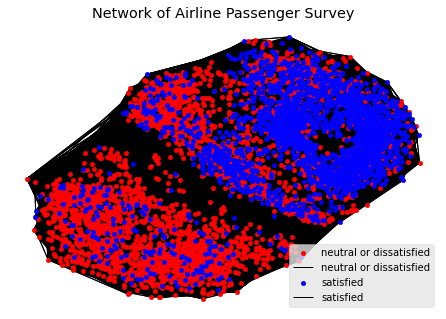

In [24]:
nx.draw(G,pos,nodelist=dissatisfied,node_size=20,node_color='r',label='neutral or dissatisfied')
nx.draw(G,pos,nodelist=satisfied,node_size=20,node_color='b',label='satisfied')
plt.title('Network of Airline Passenger Survey')
plt.legend()
plt.show()

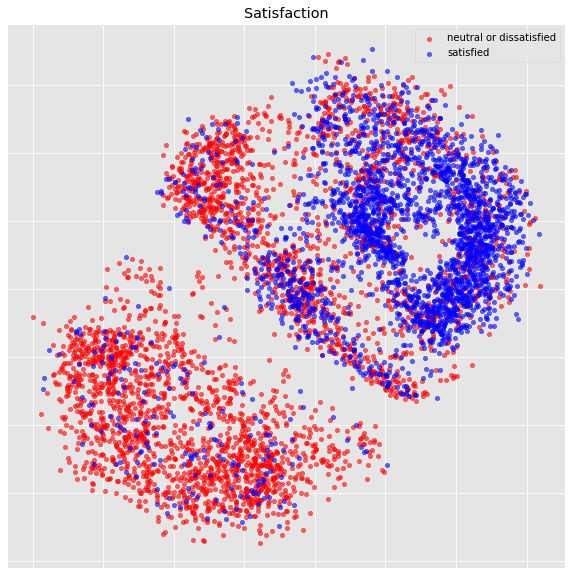

In [25]:
plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(G,pos,nodelist=dissatisfied,node_size=20,node_color='r', alpha=0.6,label='neutral or dissatisfied')
nx.draw_networkx_nodes(G,pos,nodelist=satisfied,node_size=20,node_color='b', alpha=0.6,label='satisfied')
plt.legend()
plt.title('Satisfaction')
plt.show()

<AxesSubplot:>

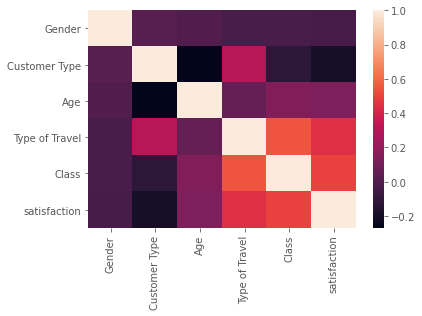

In [26]:
# correlation Map of the Attribute Variables and the Label
cormap_vars = X[['Gender','Customer Type','Age','Type of Travel','Class','satisfaction']]
cormap = cormap_vars.corr()
sns.heatmap(cormap)

In [27]:
male = df.index[df.Gender == 'Male'].tolist()
female = df.index[df.Gender == 'Female'].tolist()

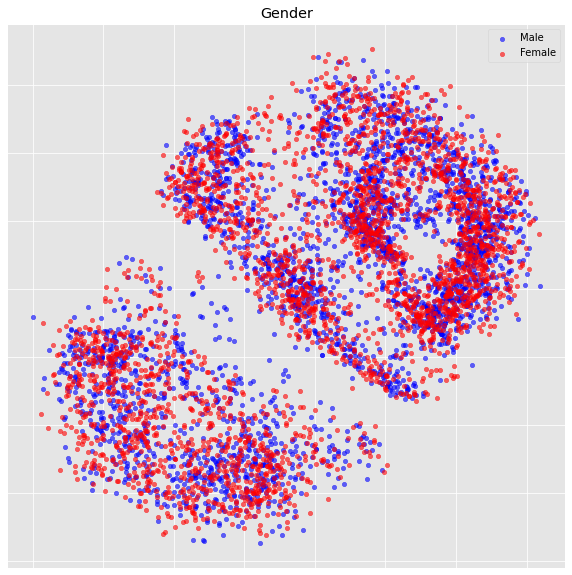

In [28]:
plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(G,pos,nodelist=male,node_size=20,node_color='b', alpha=0.6,label='Male')
nx.draw_networkx_nodes(G,pos,nodelist=female,node_size=20,node_color='r', alpha=0.6,label='Female')
plt.legend()
plt.title('Gender')
plt.show()

In [29]:
loyal = df.index[df['Customer Type'] == 'Loyal Customer'].tolist()
disloyal = df.index[df['Customer Type'] == 'disloyal Customer'].tolist()

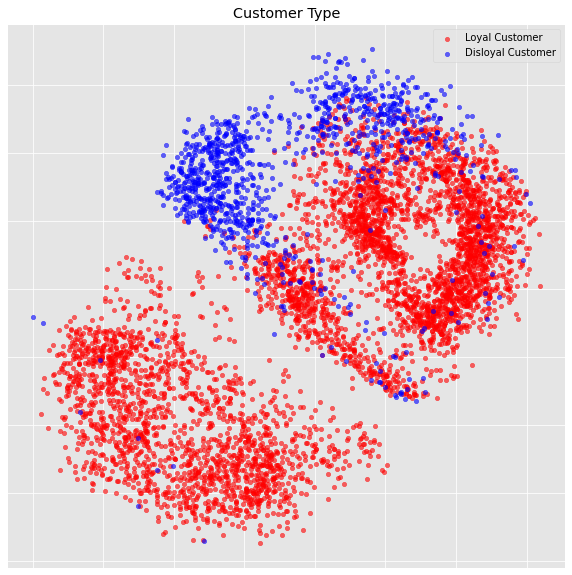

In [30]:
plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(G,pos,nodelist=loyal,node_size=20,node_color='r', alpha=0.6,label='Loyal Customer')
nx.draw_networkx_nodes(G,pos,nodelist=disloyal,node_size=20,node_color='b', alpha=0.6,label='Disloyal Customer')
plt.legend()
plt.title('Customer Type')
plt.show()

In [31]:
eco = df.index[df.Class == 'Eco'].tolist()
eco_plus = df.index[df.Class == 'Eco Plus'].tolist()
bus = df.index[df.Class == 'Business'].tolist()

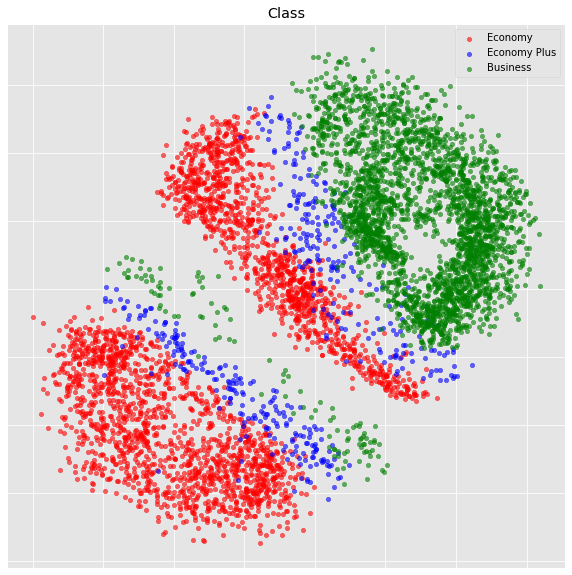

In [32]:
plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(G,pos,nodelist=eco,node_size=20,node_color='r', alpha=0.6,label='Economy')
nx.draw_networkx_nodes(G,pos,nodelist=eco_plus,node_size=20,node_color='b', alpha=0.6,label='Economy Plus')
nx.draw_networkx_nodes(G,pos,nodelist=bus,node_size=20,node_color='g', alpha=0.6,label='Business')
plt.legend()
plt.title('Class')
plt.show()

In [33]:
personal = df.index[df['Type of Travel'] == 'Personal Travel'].tolist()
business = df.index[df['Type of Travel'] == 'Business travel'].tolist()

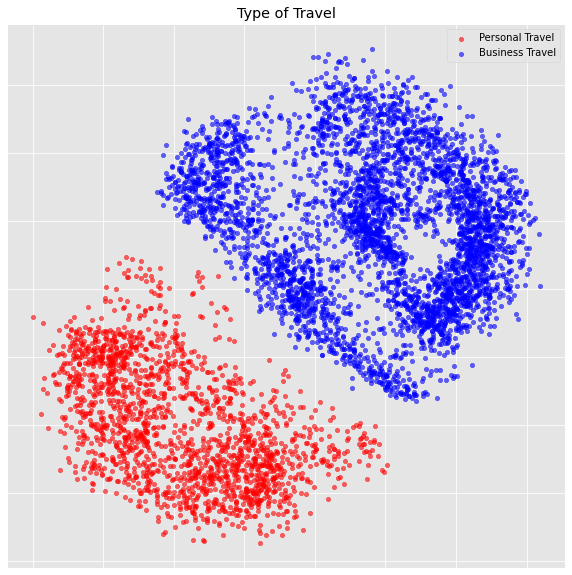

In [34]:
plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(G,pos,nodelist=personal,node_size=20,node_color='r', alpha=0.6,label='Personal Travel')
nx.draw_networkx_nodes(G,pos,nodelist=business,node_size=20,node_color='b', alpha=0.6,label = 'Business Travel')
plt.legend()
plt.title('Type of Travel')
plt.show()

In [35]:
AGE = df.Age.apply(lambda x: 0 if x < 26 else(1 if x < 39 else(2 if x < 50 else 3)))

In [36]:
age0 = AGE.index[AGE == 0].tolist()
age1 = AGE.index[AGE == 1].tolist()
age2 = AGE.index[AGE == 2].tolist()
age3 = AGE.index[AGE == 3].tolist()

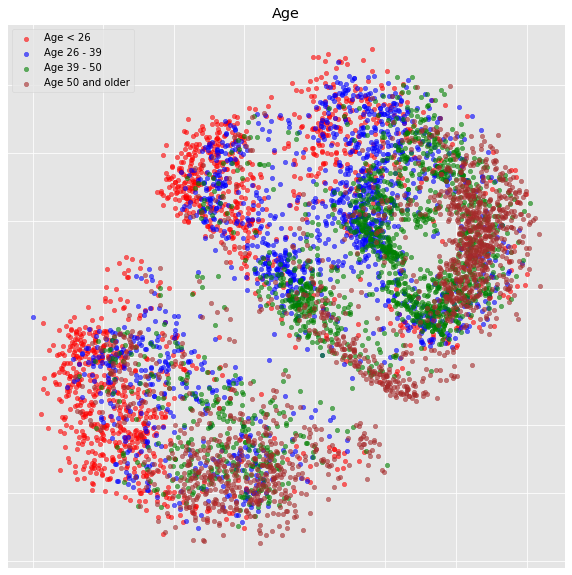

In [37]:
plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(G,pos,nodelist=age0,node_size=20,node_color='r', alpha=0.6,label = 'Age < 26')
nx.draw_networkx_nodes(G,pos,nodelist=age1,node_size=20,node_color='b', alpha=0.6,label = 'Age 26 - 39')
nx.draw_networkx_nodes(G,pos,nodelist=age2,node_size=20,node_color='g', alpha=0.6,label = 'Age 39 - 50')
nx.draw_networkx_nodes(G,pos,nodelist=age3,node_size=20,node_color='brown', alpha=0.6,label = 'Age 50 and older' )
plt.legend()
plt.title('Age')
plt.show()

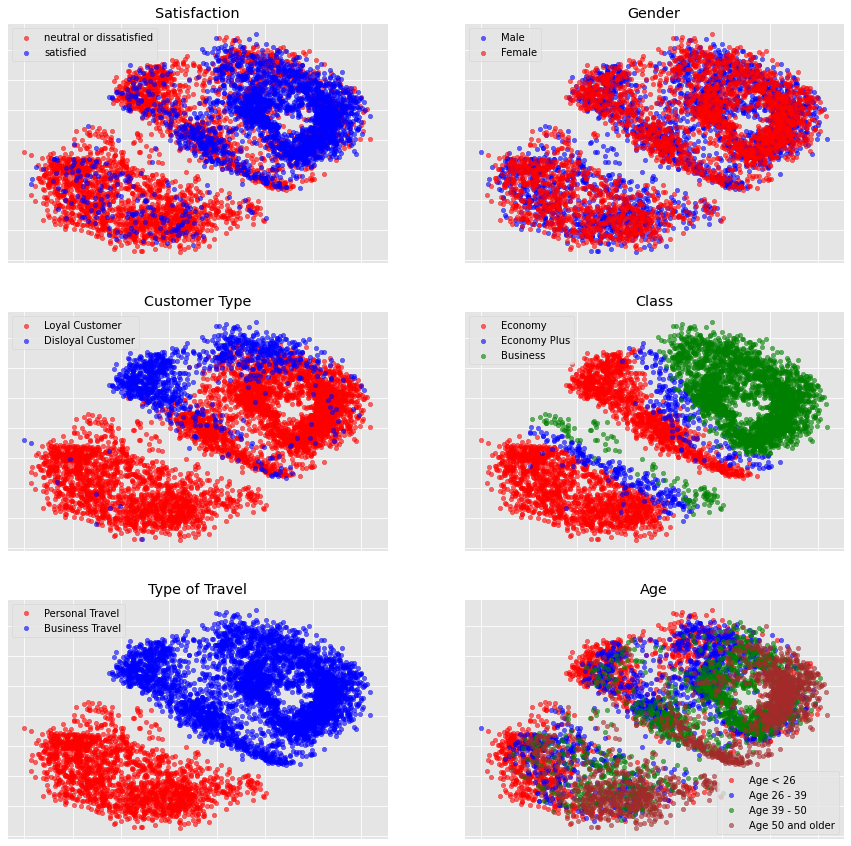

In [38]:
fig = plt.subplots(figsize=(15,15))

plt.subplot(321)
nx.draw_networkx_nodes(G,pos,nodelist=dissatisfied,node_size=20,node_color='r', alpha=0.6,label='neutral or dissatisfied')
nx.draw_networkx_nodes(G,pos,nodelist=satisfied,node_size=20,node_color='b', alpha=0.6,label='satisfied')
plt.title('Satisfaction')
plt.legend()

plt.subplot(322)
nx.draw_networkx_nodes(G,pos,nodelist=male,node_size=20,node_color='b', alpha=0.6,label='Male')
nx.draw_networkx_nodes(G,pos,nodelist=female,node_size=20,node_color='r', alpha=0.6,label='Female')
plt.title('Gender')
plt.legend()

plt.subplot(323)
nx.draw_networkx_nodes(G,pos,nodelist=loyal,node_size=20,node_color='r', alpha=0.6,label='Loyal Customer')
nx.draw_networkx_nodes(G,pos,nodelist=disloyal,node_size=20,node_color='b', alpha=0.6,label='Disloyal Customer')
plt.title('Customer Type')
plt.legend()

plt.subplot(324)
nx.draw_networkx_nodes(G,pos,nodelist=eco,node_size=20,node_color='r', alpha=0.6,label='Economy')
nx.draw_networkx_nodes(G,pos,nodelist=eco_plus,node_size=20,node_color='b', alpha=0.6,label='Economy Plus')
nx.draw_networkx_nodes(G,pos,nodelist=bus,node_size=20,node_color='g', alpha=0.6,label='Business')
plt.title('Class')
plt.legend()

plt.subplot(325)
nx.draw_networkx_nodes(G,pos,nodelist=personal,node_size=20,node_color='r', alpha=0.6,label='Personal Travel')
nx.draw_networkx_nodes(G,pos,nodelist=business,node_size=20,node_color='b', alpha=0.6,label = 'Business Travel')
plt.title('Type of Travel')
plt.legend()

plt.subplot(326)
nx.draw_networkx_nodes(G,pos,nodelist=age0,node_size=20,node_color='r', alpha=0.6,label = 'Age < 26')
nx.draw_networkx_nodes(G,pos,nodelist=age1,node_size=20,node_color='b', alpha=0.6,label = 'Age 26 - 39')
nx.draw_networkx_nodes(G,pos,nodelist=age2,node_size=20,node_color='g', alpha=0.6,label = 'Age 39 - 50')
nx.draw_networkx_nodes(G,pos,nodelist=age3,node_size=20,node_color='brown', alpha=0.6,label = 'Age 50 and older')
plt.title('Age')
plt.legend()

plt.show()


## Assign the Graph Data to a dgl Graph and Prepare the Data for Machine Learning

In [22]:
G_dgl = dgl.from_networkx(G)

G_dgl.ndata['feat'] =  torch.tensor(x_wd.values,dtype=torch.float)
G_dgl.ndata['train_mask'] = torch.zeros(len(G_dgl.nodes()), dtype=torch.bool).bernoulli(0.8)
G_dgl.ndata['label'] = torch.tensor(features)

In [23]:
G_dgl.ndata['val_mask'] = torch.empty(len(G_dgl.nodes()))
for i in range(len(G_dgl.ndata['train_mask'])):
    if G_dgl.ndata['train_mask'][i] == True:
        G_dgl.ndata['val_mask'][i] = False
    else:
        G_dgl.ndata['val_mask'][i] = True

G_dgl.ndata['val_mask'] = G_dgl.ndata['val_mask'].type(torch.bool)

In [24]:
node_features = G_dgl.ndata['feat']
node_labels = G_dgl.ndata['label']
train_mask = G_dgl.ndata['train_mask']
valid_mask = G_dgl.ndata['val_mask']
n_features = node_features.shape[1]
n_labels = int(node_labels.max().item() + 1)

In [25]:
train_nodes = (train_mask == True).nonzero(as_tuple=False)
train_nids = torch.reshape(train_nodes,(-1,))
valid_nodes = (valid_mask == True).nonzero(as_tuple=False)
valid_nids = torch.reshape(valid_nodes,(-1,))

In [26]:
len(train_nids)

4749

In [27]:
len(valid_nids)

1251

## Define the Dataloaders

In [28]:
batch_size = 50
sampler = dgl.dataloading.MultiLayerNeighborSampler([5,10])
train_dataloader = dgl.dataloading.NodeDataLoader(
    G_dgl, train_nids, sampler,
    batch_size=batch_size,
    shuffle=True,
    drop_last=False,
    num_workers=0
)

In [29]:
example_minibatch = next(iter(train_dataloader))
print(example_minibatch)

[tensor([ 885, 3367, 5728,  ..., 5917, 4847, 4530]), tensor([ 885, 3367, 5728, 1941,  505, 4856, 1192, 3069,  252, 4983, 2463, 1442,
        2244, 3810, 4846, 2365, 1534, 1111, 3226, 5367,   71, 2620,  960, 3269,
        1491, 2735, 2239, 2523, 5817, 2957, 1822,  403, 1852, 5852, 5958, 3345,
        5298, 5503, 4101,  363, 3143, 2126, 3815, 2515, 5638, 4676, 2996, 4022,
        4048, 4653]), [Block(num_src_nodes=2450, num_dst_nodes=530, num_edges=2650), Block(num_src_nodes=530, num_dst_nodes=50, num_edges=500)]]


In [30]:
input_nodes, output_nodes, bipartites = example_minibatch
print("To compute {} nodes' output we need {} nodes' input features".format(len(output_nodes), len(input_nodes)))

To compute 50 nodes' output we need 2450 nodes' input features


In [31]:
print(bipartites)

[Block(num_src_nodes=2450, num_dst_nodes=530, num_edges=2650), Block(num_src_nodes=530, num_dst_nodes=50, num_edges=500)]


In [32]:
batch_size = len(valid_nids)
valid_dataloader = dgl.dataloading.NodeDataLoader(
    G_dgl, valid_nids, sampler,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=0
)

## Define the GraphSage Model, Train and get Results

The aggregation types are named as follows:

- 'pool' = max-pooling
- 'mean' = mean aggregations
- 'lstm' = LSTM aggregation

For sum-pooling, the class SumSage is used where 'pool' refers to sum-pooling and makes used of the script in the file sage.py

Note, that the logSoftmax function is not defined in the Sage classes below for the final output layer. This is because, the logSoftmax function is automatically applied when calculating the loss using the F.cross_entropy function. For that reason, the logSoftmax function is applied separately in the training script for getting the predicted values. This is both true for the GraphSage and GCN models.

In [50]:
class SAGE(nn.Module):
    def __init__(self, in_feats, n_hidden, n_classes, n_layers,agg_type='pool'):
        super().__init__()
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.n_classes = n_classes
        self.layers = nn.ModuleList()
        self.layers.append(dglnn.SAGEConv(in_feats, n_hidden, aggregator_type=agg_type, bias=True, feat_drop=0.02,norm=Norm,activation=nn.ReLU(inplace=False)))
        for i in range(1, n_layers - 1):
            self.layers.append(dglnn.SAGEConv(n_hidden, n_hidden, aggregator_type=agg_type, bias=True, feat_drop=0.02,norm=Norm,activation=nn.ReLU(inplace=False)))
        self.layers.append(dglnn.SAGEConv(n_hidden, n_classes, aggregator_type=agg_type, bias=True, feat_drop=0.02,norm=None,activation=None))
        
    def forward(self, bipartites, x):
        for l, (layer, bipartite) in enumerate(zip(self.layers, bipartites)):
            x = layer(bipartite, x)
        return x

In [51]:
## Used for sum-pooling
class SumSAGE(nn.Module):
    def __init__(self, in_feats, n_hidden, n_classes, n_layers):
        super().__init__()
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.n_classes = n_classes
        self.layers = nn.ModuleList()
        self.layers.append(SAGEConv(in_feats, n_hidden, aggregator_type='pool', bias=True, feat_drop=0.02,norm=Norm,activation=nn.ReLU(inplace=False)))
        for i in range(1, n_layers - 1):
            self.layers.append(SAGEConv(n_hidden, n_hidden, aggregator_type='pool', bias=True, feat_drop=0.02,norm=Norm,activation=nn.ReLU(inplace=False)))
        self.layers.append(SAGEConv(n_hidden, n_classes, aggregator_type='pool', bias=True, feat_drop=0.02,norm=None,activation=None))
        
    def forward(self, bipartites, x):
        for l, (layer, bipartite) in enumerate(zip(self.layers, bipartites)):
            x = layer(bipartite, x)
            
        return x

In [52]:
#model = SumSAGE(n_features, len(x_wd.T), n_labels, 2) #n_layers
model = SAGE(n_features, len(x_wd.T), n_labels, 2, agg_type='pool') #n_layers
opt = torch.optim.Adam(model.parameters(),lr=0.002)#deine optimizer

Below the GraphSage model is trained

In [53]:
# GraphSage
best_accuracy = 0
best_model_path = 'model.pt'
epoch_losses_train = []
plot_loss_valid = []
train_acc = []
valid_acc = []
dur = []

for epoch in range(400):
    t0 = time.time()
    model.train()
    loss_epoch = 0
    accuracy_epoch = 0
    for step, (input_nodes, output_nodes, bipartites) in enumerate(train_dataloader):
        inputs = node_features[input_nodes]
        labels = node_labels[output_nodes]
        logits = model(bipartites, inputs)
        predictions = F.log_softmax(logits,dim=1)

        loss = F.cross_entropy(logits, labels)
        loss_epoch += loss.detach().item()
        opt.zero_grad()
        loss.backward()
        opt.step()

        accuracy = accuracy_score(labels.numpy(), predictions.argmax(1).detach().numpy())
        accuracy_epoch += accuracy
    accuracy_epoch /= (step + 1)
    loss_epoch /= (step + 1)
    epoch_losses_train.append(loss_epoch)
    train_acc.append(accuracy_epoch)
    print('Epoch: {}, Training Accuracy: {:.3f}, Training Loss: {:.3f}'.format(epoch, accuracy_epoch, loss_epoch))
        
    model.eval()
    
    predictions = []
    labels = []
    with torch.no_grad():
        for input_nodes, output_nodes, bipartites in valid_dataloader:
            inputs = node_features[input_nodes]
            labels.append(node_labels[output_nodes].numpy())
            predictions.append(F.log_softmax(model(bipartites, inputs),dim=1).argmax(1).numpy())
            valid_logits = model(bipartites, inputs)
            valid_labels = node_labels[output_nodes]
            valid_loss = F.cross_entropy(valid_logits, valid_labels)

        predictions = np.concatenate(predictions)
        labels = np.concatenate(labels)
        
        accuracy = accuracy_score(labels, predictions)
        dur.append(time.time() - t0)
        print('Epoch: {}, Validation Accuracy: {:.3f}, Validation Loss: {:.3f}, Time: {:.4f}'.format(epoch, accuracy, valid_loss.item(), np.mean(dur)))
        valid_acc.append(accuracy.item())
        plot_loss_valid.append(valid_loss.item())
    
torch.save(model.state_dict(), best_model_path)


Epoch: 0, Training Accuracy: 0.722, Training Loss: 0.563
Epoch: 0, Validation Accuracy: 0.836, Validation Loss: 0.441, Time: 1.2993
Epoch: 1, Training Accuracy: 0.814, Training Loss: 0.444
Epoch: 1, Validation Accuracy: 0.851, Validation Loss: 0.389, Time: 1.4027
Epoch: 2, Training Accuracy: 0.835, Training Loss: 0.401
Epoch: 2, Validation Accuracy: 0.849, Validation Loss: 0.373, Time: 1.4579
Epoch: 3, Training Accuracy: 0.849, Training Loss: 0.371
Epoch: 3, Validation Accuracy: 0.867, Validation Loss: 0.352, Time: 1.4696
Epoch: 4, Training Accuracy: 0.858, Training Loss: 0.360
Epoch: 4, Validation Accuracy: 0.881, Validation Loss: 0.325, Time: 1.4779
Epoch: 5, Training Accuracy: 0.861, Training Loss: 0.348
Epoch: 5, Validation Accuracy: 0.884, Validation Loss: 0.307, Time: 1.4338
Epoch: 6, Training Accuracy: 0.868, Training Loss: 0.335
Epoch: 6, Validation Accuracy: 0.884, Validation Loss: 0.314, Time: 1.4174
Epoch: 7, Training Accuracy: 0.865, Training Loss: 0.332
Epoch: 7, Validatio

Epoch: 62, Training Accuracy: 0.931, Training Loss: 0.179
Epoch: 62, Validation Accuracy: 0.945, Validation Loss: 0.152, Time: 1.2962
Epoch: 63, Training Accuracy: 0.932, Training Loss: 0.176
Epoch: 63, Validation Accuracy: 0.931, Validation Loss: 0.163, Time: 1.2972
Epoch: 64, Training Accuracy: 0.926, Training Loss: 0.183
Epoch: 64, Validation Accuracy: 0.937, Validation Loss: 0.147, Time: 1.2944
Epoch: 65, Training Accuracy: 0.931, Training Loss: 0.175
Epoch: 65, Validation Accuracy: 0.946, Validation Loss: 0.148, Time: 1.2920
Epoch: 66, Training Accuracy: 0.935, Training Loss: 0.169
Epoch: 66, Validation Accuracy: 0.942, Validation Loss: 0.151, Time: 1.2891
Epoch: 67, Training Accuracy: 0.933, Training Loss: 0.175
Epoch: 67, Validation Accuracy: 0.940, Validation Loss: 0.159, Time: 1.2864
Epoch: 68, Training Accuracy: 0.932, Training Loss: 0.181
Epoch: 68, Validation Accuracy: 0.938, Validation Loss: 0.154, Time: 1.2842
Epoch: 69, Training Accuracy: 0.931, Training Loss: 0.173
Epoc

Epoch: 123, Training Accuracy: 0.937, Training Loss: 0.154
Epoch: 123, Validation Accuracy: 0.944, Validation Loss: 0.149, Time: 1.3232
Epoch: 124, Training Accuracy: 0.939, Training Loss: 0.157
Epoch: 124, Validation Accuracy: 0.946, Validation Loss: 0.137, Time: 1.3241
Epoch: 125, Training Accuracy: 0.937, Training Loss: 0.154
Epoch: 125, Validation Accuracy: 0.944, Validation Loss: 0.140, Time: 1.3262
Epoch: 126, Training Accuracy: 0.937, Training Loss: 0.165
Epoch: 126, Validation Accuracy: 0.944, Validation Loss: 0.141, Time: 1.3285
Epoch: 127, Training Accuracy: 0.934, Training Loss: 0.161
Epoch: 127, Validation Accuracy: 0.949, Validation Loss: 0.142, Time: 1.3302
Epoch: 128, Training Accuracy: 0.929, Training Loss: 0.169
Epoch: 128, Validation Accuracy: 0.950, Validation Loss: 0.133, Time: 1.3312
Epoch: 129, Training Accuracy: 0.937, Training Loss: 0.156
Epoch: 129, Validation Accuracy: 0.949, Validation Loss: 0.138, Time: 1.3323
Epoch: 130, Training Accuracy: 0.938, Training L

Epoch: 184, Training Accuracy: 0.937, Training Loss: 0.156
Epoch: 184, Validation Accuracy: 0.939, Validation Loss: 0.142, Time: 1.3623
Epoch: 185, Training Accuracy: 0.938, Training Loss: 0.153
Epoch: 185, Validation Accuracy: 0.949, Validation Loss: 0.134, Time: 1.3630
Epoch: 186, Training Accuracy: 0.942, Training Loss: 0.151
Epoch: 186, Validation Accuracy: 0.951, Validation Loss: 0.136, Time: 1.3636
Epoch: 187, Training Accuracy: 0.942, Training Loss: 0.152
Epoch: 187, Validation Accuracy: 0.948, Validation Loss: 0.132, Time: 1.3648
Epoch: 188, Training Accuracy: 0.939, Training Loss: 0.147
Epoch: 188, Validation Accuracy: 0.949, Validation Loss: 0.140, Time: 1.3653
Epoch: 189, Training Accuracy: 0.941, Training Loss: 0.146
Epoch: 189, Validation Accuracy: 0.943, Validation Loss: 0.153, Time: 1.3657
Epoch: 190, Training Accuracy: 0.944, Training Loss: 0.145
Epoch: 190, Validation Accuracy: 0.948, Validation Loss: 0.135, Time: 1.3668
Epoch: 191, Training Accuracy: 0.943, Training L

Epoch: 245, Training Accuracy: 0.941, Training Loss: 0.145
Epoch: 245, Validation Accuracy: 0.942, Validation Loss: 0.140, Time: 1.3971
Epoch: 246, Training Accuracy: 0.944, Training Loss: 0.145
Epoch: 246, Validation Accuracy: 0.944, Validation Loss: 0.135, Time: 1.3974
Epoch: 247, Training Accuracy: 0.943, Training Loss: 0.141
Epoch: 247, Validation Accuracy: 0.948, Validation Loss: 0.130, Time: 1.3978
Epoch: 248, Training Accuracy: 0.946, Training Loss: 0.137
Epoch: 248, Validation Accuracy: 0.944, Validation Loss: 0.136, Time: 1.3979
Epoch: 249, Training Accuracy: 0.946, Training Loss: 0.137
Epoch: 249, Validation Accuracy: 0.940, Validation Loss: 0.143, Time: 1.3982
Epoch: 250, Training Accuracy: 0.941, Training Loss: 0.142
Epoch: 250, Validation Accuracy: 0.945, Validation Loss: 0.138, Time: 1.3985
Epoch: 251, Training Accuracy: 0.946, Training Loss: 0.144
Epoch: 251, Validation Accuracy: 0.946, Validation Loss: 0.133, Time: 1.3987
Epoch: 252, Training Accuracy: 0.944, Training L

Epoch: 306, Training Accuracy: 0.946, Training Loss: 0.138
Epoch: 306, Validation Accuracy: 0.954, Validation Loss: 0.132, Time: 1.4145
Epoch: 307, Training Accuracy: 0.947, Training Loss: 0.134
Epoch: 307, Validation Accuracy: 0.950, Validation Loss: 0.129, Time: 1.4147
Epoch: 308, Training Accuracy: 0.945, Training Loss: 0.131
Epoch: 308, Validation Accuracy: 0.951, Validation Loss: 0.126, Time: 1.4149
Epoch: 309, Training Accuracy: 0.944, Training Loss: 0.136
Epoch: 309, Validation Accuracy: 0.939, Validation Loss: 0.141, Time: 1.4151
Epoch: 310, Training Accuracy: 0.948, Training Loss: 0.134
Epoch: 310, Validation Accuracy: 0.954, Validation Loss: 0.124, Time: 1.4153
Epoch: 311, Training Accuracy: 0.947, Training Loss: 0.136
Epoch: 311, Validation Accuracy: 0.949, Validation Loss: 0.127, Time: 1.4155
Epoch: 312, Training Accuracy: 0.948, Training Loss: 0.130
Epoch: 312, Validation Accuracy: 0.942, Validation Loss: 0.135, Time: 1.4158
Epoch: 313, Training Accuracy: 0.943, Training L

Epoch: 367, Training Accuracy: 0.949, Training Loss: 0.135
Epoch: 367, Validation Accuracy: 0.951, Validation Loss: 0.126, Time: 1.4168
Epoch: 368, Training Accuracy: 0.942, Training Loss: 0.134
Epoch: 368, Validation Accuracy: 0.949, Validation Loss: 0.128, Time: 1.4165
Epoch: 369, Training Accuracy: 0.942, Training Loss: 0.135
Epoch: 369, Validation Accuracy: 0.944, Validation Loss: 0.140, Time: 1.4157
Epoch: 370, Training Accuracy: 0.949, Training Loss: 0.134
Epoch: 370, Validation Accuracy: 0.949, Validation Loss: 0.132, Time: 1.4149
Epoch: 371, Training Accuracy: 0.951, Training Loss: 0.133
Epoch: 371, Validation Accuracy: 0.947, Validation Loss: 0.130, Time: 1.4143
Epoch: 372, Training Accuracy: 0.943, Training Loss: 0.140
Epoch: 372, Validation Accuracy: 0.950, Validation Loss: 0.125, Time: 1.4148
Epoch: 373, Training Accuracy: 0.944, Training Loss: 0.133
Epoch: 373, Validation Accuracy: 0.942, Validation Loss: 0.138, Time: 1.4152
Epoch: 374, Training Accuracy: 0.948, Training L

Epoch: 428, Training Accuracy: 0.945, Training Loss: 0.137
Epoch: 428, Validation Accuracy: 0.949, Validation Loss: 0.130, Time: 1.3967
Epoch: 429, Training Accuracy: 0.948, Training Loss: 0.126
Epoch: 429, Validation Accuracy: 0.953, Validation Loss: 0.126, Time: 1.3961
Epoch: 430, Training Accuracy: 0.950, Training Loss: 0.130
Epoch: 430, Validation Accuracy: 0.954, Validation Loss: 0.123, Time: 1.3959
Epoch: 431, Training Accuracy: 0.948, Training Loss: 0.131
Epoch: 431, Validation Accuracy: 0.949, Validation Loss: 0.135, Time: 1.3961
Epoch: 432, Training Accuracy: 0.947, Training Loss: 0.134
Epoch: 432, Validation Accuracy: 0.947, Validation Loss: 0.130, Time: 1.3964
Epoch: 433, Training Accuracy: 0.948, Training Loss: 0.132
Epoch: 433, Validation Accuracy: 0.951, Validation Loss: 0.131, Time: 1.3966
Epoch: 434, Training Accuracy: 0.947, Training Loss: 0.138
Epoch: 434, Validation Accuracy: 0.942, Validation Loss: 0.134, Time: 1.3967
Epoch: 435, Training Accuracy: 0.946, Training L

Epoch: 489, Training Accuracy: 0.943, Training Loss: 0.132
Epoch: 489, Validation Accuracy: 0.956, Validation Loss: 0.120, Time: 1.3812
Epoch: 490, Training Accuracy: 0.951, Training Loss: 0.125
Epoch: 490, Validation Accuracy: 0.955, Validation Loss: 0.124, Time: 1.3815
Epoch: 491, Training Accuracy: 0.950, Training Loss: 0.129
Epoch: 491, Validation Accuracy: 0.950, Validation Loss: 0.126, Time: 1.3817
Epoch: 492, Training Accuracy: 0.948, Training Loss: 0.129
Epoch: 492, Validation Accuracy: 0.953, Validation Loss: 0.123, Time: 1.3820
Epoch: 493, Training Accuracy: 0.949, Training Loss: 0.136
Epoch: 493, Validation Accuracy: 0.957, Validation Loss: 0.123, Time: 1.3821
Epoch: 494, Training Accuracy: 0.944, Training Loss: 0.137
Epoch: 494, Validation Accuracy: 0.947, Validation Loss: 0.139, Time: 1.3815
Epoch: 495, Training Accuracy: 0.948, Training Loss: 0.133
Epoch: 495, Validation Accuracy: 0.946, Validation Loss: 0.137, Time: 1.3810
Epoch: 496, Training Accuracy: 0.947, Training L

Epoch: 550, Training Accuracy: 0.949, Training Loss: 0.121
Epoch: 550, Validation Accuracy: 0.949, Validation Loss: 0.132, Time: 1.3749
Epoch: 551, Training Accuracy: 0.950, Training Loss: 0.127
Epoch: 551, Validation Accuracy: 0.954, Validation Loss: 0.127, Time: 1.3751
Epoch: 552, Training Accuracy: 0.948, Training Loss: 0.130
Epoch: 552, Validation Accuracy: 0.953, Validation Loss: 0.128, Time: 1.3753
Epoch: 553, Training Accuracy: 0.948, Training Loss: 0.128
Epoch: 553, Validation Accuracy: 0.950, Validation Loss: 0.125, Time: 1.3754
Epoch: 554, Training Accuracy: 0.948, Training Loss: 0.129
Epoch: 554, Validation Accuracy: 0.951, Validation Loss: 0.124, Time: 1.3757
Epoch: 555, Training Accuracy: 0.952, Training Loss: 0.119
Epoch: 555, Validation Accuracy: 0.950, Validation Loss: 0.129, Time: 1.3757
Epoch: 556, Training Accuracy: 0.951, Training Loss: 0.124
Epoch: 556, Validation Accuracy: 0.948, Validation Loss: 0.129, Time: 1.3760
Epoch: 557, Training Accuracy: 0.950, Training L

Epoch: 611, Training Accuracy: 0.952, Training Loss: 0.127
Epoch: 611, Validation Accuracy: 0.952, Validation Loss: 0.124, Time: 1.3790
Epoch: 612, Training Accuracy: 0.950, Training Loss: 0.128
Epoch: 612, Validation Accuracy: 0.942, Validation Loss: 0.138, Time: 1.3792
Epoch: 613, Training Accuracy: 0.950, Training Loss: 0.126
Epoch: 613, Validation Accuracy: 0.945, Validation Loss: 0.137, Time: 1.3792
Epoch: 614, Training Accuracy: 0.952, Training Loss: 0.126
Epoch: 614, Validation Accuracy: 0.956, Validation Loss: 0.123, Time: 1.3793
Epoch: 615, Training Accuracy: 0.945, Training Loss: 0.130
Epoch: 615, Validation Accuracy: 0.951, Validation Loss: 0.123, Time: 1.3795
Epoch: 616, Training Accuracy: 0.951, Training Loss: 0.127
Epoch: 616, Validation Accuracy: 0.953, Validation Loss: 0.120, Time: 1.3796
Epoch: 617, Training Accuracy: 0.946, Training Loss: 0.132
Epoch: 617, Validation Accuracy: 0.940, Validation Loss: 0.136, Time: 1.3797
Epoch: 618, Training Accuracy: 0.949, Training L

Epoch: 672, Training Accuracy: 0.949, Training Loss: 0.126
Epoch: 672, Validation Accuracy: 0.946, Validation Loss: 0.134, Time: 1.3895
Epoch: 673, Training Accuracy: 0.949, Training Loss: 0.135
Epoch: 673, Validation Accuracy: 0.954, Validation Loss: 0.129, Time: 1.3895
Epoch: 674, Training Accuracy: 0.952, Training Loss: 0.122
Epoch: 674, Validation Accuracy: 0.955, Validation Loss: 0.123, Time: 1.3895
Epoch: 675, Training Accuracy: 0.948, Training Loss: 0.128
Epoch: 675, Validation Accuracy: 0.950, Validation Loss: 0.126, Time: 1.3890
Epoch: 676, Training Accuracy: 0.948, Training Loss: 0.128
Epoch: 676, Validation Accuracy: 0.957, Validation Loss: 0.120, Time: 1.3887
Epoch: 677, Training Accuracy: 0.949, Training Loss: 0.126
Epoch: 677, Validation Accuracy: 0.954, Validation Loss: 0.129, Time: 1.3882
Epoch: 678, Training Accuracy: 0.951, Training Loss: 0.123
Epoch: 678, Validation Accuracy: 0.958, Validation Loss: 0.122, Time: 1.3878
Epoch: 679, Training Accuracy: 0.952, Training L

Epoch: 733, Training Accuracy: 0.951, Training Loss: 0.124
Epoch: 733, Validation Accuracy: 0.950, Validation Loss: 0.127, Time: 1.3940
Epoch: 734, Training Accuracy: 0.947, Training Loss: 0.131
Epoch: 734, Validation Accuracy: 0.953, Validation Loss: 0.121, Time: 1.3943
Epoch: 735, Training Accuracy: 0.950, Training Loss: 0.123
Epoch: 735, Validation Accuracy: 0.954, Validation Loss: 0.123, Time: 1.3945
Epoch: 736, Training Accuracy: 0.951, Training Loss: 0.124
Epoch: 736, Validation Accuracy: 0.953, Validation Loss: 0.129, Time: 1.3946
Epoch: 737, Training Accuracy: 0.949, Training Loss: 0.128
Epoch: 737, Validation Accuracy: 0.953, Validation Loss: 0.126, Time: 1.3948
Epoch: 738, Training Accuracy: 0.950, Training Loss: 0.126
Epoch: 738, Validation Accuracy: 0.955, Validation Loss: 0.122, Time: 1.3949
Epoch: 739, Training Accuracy: 0.952, Training Loss: 0.125
Epoch: 739, Validation Accuracy: 0.954, Validation Loss: 0.125, Time: 1.3950
Epoch: 740, Training Accuracy: 0.946, Training L

Epoch: 794, Training Accuracy: 0.951, Training Loss: 0.120
Epoch: 794, Validation Accuracy: 0.957, Validation Loss: 0.119, Time: 1.3946
Epoch: 795, Training Accuracy: 0.949, Training Loss: 0.126
Epoch: 795, Validation Accuracy: 0.953, Validation Loss: 0.128, Time: 1.3944
Epoch: 796, Training Accuracy: 0.950, Training Loss: 0.124
Epoch: 796, Validation Accuracy: 0.952, Validation Loss: 0.131, Time: 1.3945
Epoch: 797, Training Accuracy: 0.953, Training Loss: 0.118
Epoch: 797, Validation Accuracy: 0.959, Validation Loss: 0.124, Time: 1.3946
Epoch: 798, Training Accuracy: 0.950, Training Loss: 0.125
Epoch: 798, Validation Accuracy: 0.956, Validation Loss: 0.125, Time: 1.3948
Epoch: 799, Training Accuracy: 0.951, Training Loss: 0.124
Epoch: 799, Validation Accuracy: 0.953, Validation Loss: 0.126, Time: 1.3949


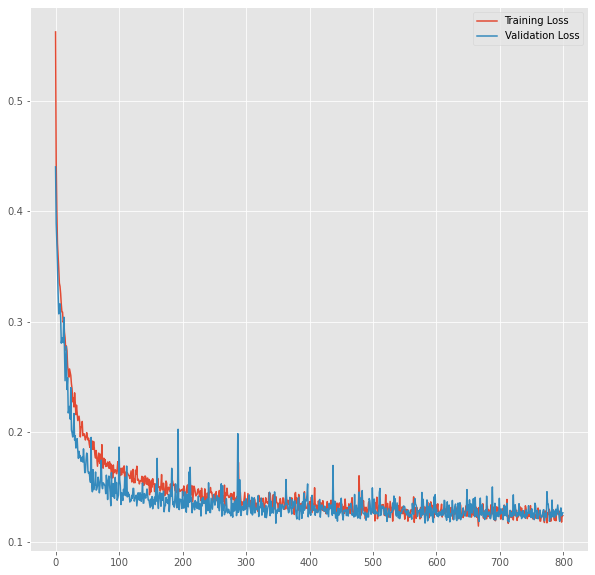

In [54]:
plt.figure(figsize=(10,10))
plt.plot(epoch_losses_train, label='Training Loss')
plt.plot(plot_loss_valid, label='Validation Loss')
plt.legend()
plt.show()

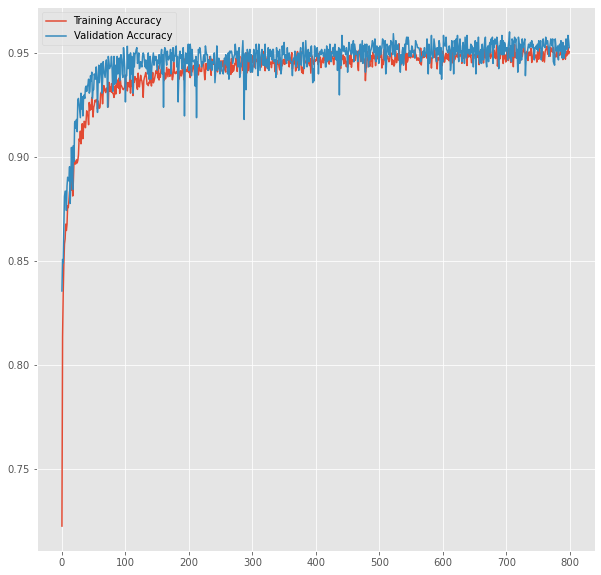

In [55]:
plt.figure(figsize=(10,10))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(valid_acc, label='Validation Accuracy')
plt.legend()
plt.show()

In [56]:
print('Training Accuracy: {}'.format(train_acc[-1]))
print('Validation Accuracy: {}'.format(valid_acc[-1]))

Training Accuracy: 0.9508100147275405
Validation Accuracy: 0.9527824620573356


In [57]:
np.argmax(valid_acc)

705

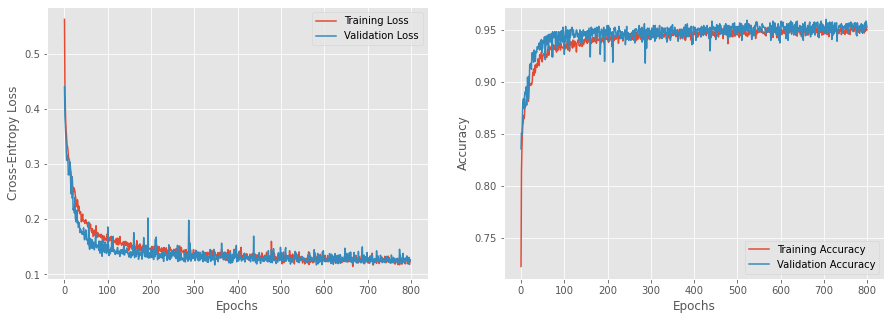

In [58]:
plt.subplots(figsize=(15,5))

plt.subplot(121)
plt.plot(epoch_losses_train, label='Training Loss')
plt.plot(plot_loss_valid, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend()

plt.subplot(122)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(valid_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [59]:
# shows the model parameters of the GraphSage model
model.parameters

<bound method Module.parameters of SAGE(
  (layers): ModuleList(
    (0): SAGEConv(
      (feat_drop): Dropout(p=0.02, inplace=False)
      (activation): ReLU()
      (fc_pool): Linear(in_features=24, out_features=24, bias=True)
      (fc_self): Linear(in_features=24, out_features=24, bias=False)
      (fc_neigh): Linear(in_features=24, out_features=24, bias=False)
    )
    (1): SAGEConv(
      (feat_drop): Dropout(p=0.02, inplace=False)
      (fc_pool): Linear(in_features=24, out_features=24, bias=True)
      (fc_self): Linear(in_features=24, out_features=2, bias=False)
      (fc_neigh): Linear(in_features=24, out_features=2, bias=False)
    )
  )
)>

## Graph Convolutional Network

Below the dgl data is reset to 30% training and 70 validation data which is then used for the GCN.

In [33]:
G_dgl.ndata['feat'] =  torch.tensor(x_wd.values,dtype=torch.float)
G_dgl.ndata['train_mask'] = torch.zeros(len(G_dgl.nodes()), dtype=torch.bool).bernoulli(0.3)
G_dgl.ndata['label'] = torch.tensor(features)

G_dgl.ndata['val_mask'] = torch.empty(len(G_dgl.nodes()))
for i in range(len(G_dgl.ndata['train_mask'])):
    if G_dgl.ndata['train_mask'][i] == True:
        G_dgl.ndata['val_mask'][i] = False
    else:
        G_dgl.ndata['val_mask'][i] = True

G_dgl.ndata['val_mask'] = G_dgl.ndata['val_mask'].type(torch.bool)

node_features = G_dgl.ndata['feat']
node_labels = G_dgl.ndata['label']
train_mask = G_dgl.ndata['train_mask']
valid_mask = G_dgl.ndata['val_mask']
n_features = node_features.shape[1]
n_labels = int(node_labels.max().item() + 1)

Define the GCN network

In [34]:
class GCN(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats):
        super().__init__()
        self.conv1 = dglnn.pytorch.conv.GraphConv(
            in_feats=in_feats, out_feats=hid_feats,norm='both', weight=True, bias=True, activation=nn.ReLU(inplace=False))
        
        self.conv2 = dglnn.pytorch.conv.GraphConv(
            in_feats=hid_feats, out_feats=out_feats,norm='both', weight=True, bias=True, activation=None)
        
    def forward(self, graph, inputs):
        h = self.conv1(graph, inputs)
        h = self.conv2(graph, h)
        return h

Compile the model

In [35]:
model_gcn = GCN(n_features, len(x_wd.T) , n_labels) # 
opt = torch.optim.Adam(model_gcn.parameters(),lr=0.002)#GCN

In [36]:
def evaluate(model_gcn, graph, features, labels, mask):
    model.eval()
    with torch.no_grad():
        logits = model_gcn(graph, features)
        logits = logits[mask]
        labels = labels[mask]
        preds = F.log_softmax(logits,dim=1)
        _, indices = torch.max(preds, dim=1)
        correct = torch.sum(indices == labels)
        return correct.item() * 1.0 / len(labels)

Train the model

In [37]:
#model = GCN(in_feats=n_features, hid_feats_1=128, hid_feats_2=128, out_feats=n_labels)
#opt = torch.optim.Adam(model.parameters(),lr=1e-2)
plot_loss_train = []
plot_loss_val = []
valid_acc = []
train_acc = []
dur = []
for epoch in range(1000):
    t0 = time.time()
    model_gcn.train()
    # forward propagation by using all nodes
    logits = model_gcn(G_dgl, node_features)
    # compute loss
    loss_train = F.cross_entropy(logits[train_mask], node_labels[train_mask])
    acc_train = evaluate(model_gcn, G_dgl, node_features, node_labels, train_mask)
    train_acc.append(acc_train)
    plot_loss_train.append(loss_train.item())
    opt.zero_grad()
    loss_train.backward()
    opt.step()
    
    model.eval()
    
    # compute validation accuracy
    with torch.no_grad():
        acc_val = evaluate(model_gcn, G_dgl, node_features, node_labels, valid_mask)
        loss_val = F.cross_entropy(logits[valid_mask], node_labels[valid_mask])
        valid_acc.append(acc_val)
        plot_loss_val.append(loss_val.item())
    # backward propagation
    
    dur.append(time.time() - t0)
    if epoch % 10 == 0:
        print('Epoch: {}, train loss: {:.4f}, validation loss: {:.4f}, training accuracy: {:.4f}, validation accuracy: {:.4f}, Time: {:.4f}'.format(epoch,loss_train.item(),loss_val.item(),acc_train,acc_val,np.mean(dur)))


NameError: name 'model' is not defined

In [ ]:
plt.subplots(figsize=(15,5))

plt.subplot(121)
plt.plot(plot_loss_train,label='Training Loss')
plt.plot(plot_loss_val,label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend()

plt.subplot(122)
plt.plot(train_acc,label='Training Accuracy')
plt.plot(valid_acc,label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
val_tens = torch.tensor(features)
_, indices_val = torch.max(logits[valid_mask], dim=1)
val_lab = val_tens[valid_mask]
train_lab = val_tens[train_mask]
_, indices_train = torch.max(logits[train_mask], dim=1)

print('Classification Accuracy validation set {}'.format(accuracy_score(val_lab,indices_val)))
print('-------------------------------------------------------------')
print('Classification Accuracy training set {}'.format(accuracy_score(train_lab,indices_train)))
print('-------------------------------------------------------------')
print('Confusion Matrix validation set:')
print(confusion_matrix(val_lab, indices_val))
print('-------------------------------------------------------------')
print('Confusion Matrix training set:')
print(confusion_matrix(train_lab,indices_train))


In [ ]:
model_gcn.parameters

In [68]:
# gender
gend_alpha0 = 0.60
gend_beta1 = 0.40

aff_gend = np.array([[gend_alpha0,gend_beta1],
                     [gend_beta1,gend_alpha0]])

# customer type (loyal vs disoyal)

type_alpha0 = 0.8
type_beta1 = 0.5

aff_type = np.array([[type_alpha0, type_beta1],
                     [type_beta1, type_alpha0]])


# age
age_alpha0 = 0.90
age_beta1 = 0.80
age_beta2 = 0.60
age_beta3 = 0.40

aff_age = np.array([[age_alpha0,age_beta1,age_beta2,age_beta3],
                    [age_beta1,age_alpha0,age_beta1,age_beta2],
                    [age_beta2,age_beta1,age_alpha0,age_beta1],
                    [age_beta3,age_beta2,age_beta1,age_alpha0]])


# Type of travel
trav_type_alpha0 = 0.80
trav_type_beta1 = 0.20

aff_trav_type = np.array([[trav_type_alpha0, trav_type_beta1],
                          [trav_type_beta1, trav_type_alpha0]])

# Class

class_alpha0 = 0.85
class_beta1 = 0.60
class_beta2 = 0.40

aff_class = np.array([[class_alpha0, class_beta1, class_beta2],
                      [class_beta1, class_alpha0, class_beta1],
                      [class_beta2, class_beta1, class_alpha0]])


aff = {0:aff_gend, 1:aff_type, 2:aff_age, 3:aff_trav_type, 4:aff_class}

In [69]:
x = test_gen.to_numpy()
x = x.astype(int)
x = x.T

P_u_v = np.empty((len(x.T),len(x.T)))
prob_u_v = np.empty((len(x),1))
u = np.empty((len(x),1))
v = np.empty((len(x),1))

# create probability for connection between u and v
for i in range(len(x.T)):
    u = x[:,i]

    for k in range(len(x.T)):
        v = x[:,k]

        for j in range(len(x)):
            aff_current = aff[j]
            prob_u_v[j] = aff_current[u[j],v[j]]

        P_u_v[i,k] = np.prod(prob_u_v)

In [70]:
A = np.triu(P_u_v,1)

for i in range(len(P_u_v)):
    for j in range(len(P_u_v)):
        if A[i,j] > np.random.rand():
            A[i,j] = 1
        else:
            A[i,j] = 0

In [71]:
A = A + A.T

In [72]:
G_test = nx.from_numpy_matrix(A)

In [73]:
test_features = pd.Series(TEST.satisfaction)

In [74]:
G_dgl_test = dgl.from_networkx(G_test)
feat_test = TEST.drop(columns=['satisfaction'])
feat_test = pd.get_dummies(data=feat_test,columns=['Customer Type','Type of Travel','Gender'])
feat_test[['Age','Departure Delay in Minutes','Flight Distance']] = normalize(feat_test[['Age','Departure Delay in Minutes','Flight Distance']])

G_dgl_test.ndata['feat'] =  torch.tensor(feat_test.values,dtype=torch.float)
G_dgl_test.ndata['label'] = torch.tensor(test_features)

In [75]:
node_features = G_dgl_test.ndata['feat']
node_labels = G_dgl_test.ndata['label']
test_nids = G_dgl_test.nodes()
n_features = node_features.shape[1]
n_labels = int(node_labels.max().item() + 1)

In [76]:
def inference(model, graph, input_features, batch_size):
    nodes = torch.arange(graph.number_of_nodes())
    
    sampler = dgl.dataloading.MultiLayerNeighborSampler([5,10]) 
    dataloader = dgl.dataloading.NodeDataLoader(
        graph, nodes, sampler,
        batch_size=batch_size,
        shuffle=False,
        drop_last=False,
        num_workers=0)
    
    with torch.no_grad():
        for l, layer in enumerate(model.layers):
            output_features = torch.zeros(
                graph.number_of_nodes(), model.n_hidden if l != model.n_layers - 1 else model.n_classes)

            for input_nodes, output_nodes, bipartites in tqdm.tqdm(dataloader):
                bipartite = bipartites[0]
                x = input_features[input_nodes]
                x = layer(bipartite, x)
                output_features[output_nodes] = x
            input_features = output_features
    return output_features

In [77]:
model.load_state_dict(torch.load('model.pt'))
all_logits = inference(model, G_dgl_test, node_features, 6000)

100%|██████████| 1/1 [00:00<00:00, 20.25it/s]


In [78]:
test_predictions = F.log_softmax(all_logits[test_nids],dim=1).argmax(1)
test_labels = node_labels[test_nids]
test_accuracy = sklearn.metrics.accuracy_score(test_predictions.numpy(), test_labels.numpy())
print('Test accuracy:', test_accuracy)

Test accuracy: 0.9401666666666667


In [79]:
print('Classification Accuracy test set {}'.format(accuracy_score(test_labels.numpy(),test_predictions.numpy())))
print('-------------------------------------------------------------')
print('Confusion Matrix test set:')
print(confusion_matrix(test_labels.numpy(),test_predictions.numpy()))

Classification Accuracy test set 0.9401666666666667
-------------------------------------------------------------
Confusion Matrix test set:
[[3298   76]
 [ 283 2343]]


In [80]:
sklearn.metrics.f1_score(test_labels.numpy(),test_predictions.numpy(),average='micro')

0.9401666666666667

In [81]:
test_loss = F.cross_entropy(all_logits[test_nids],test_labels).numpy()
test_loss

array(0.1559147, dtype=float32)

In [82]:
model.layers

ModuleList(
  (0): SAGEConv(
    (feat_drop): Dropout(p=0.02, inplace=False)
    (activation): ReLU()
    (fc_pool): Linear(in_features=24, out_features=24, bias=True)
    (fc_self): Linear(in_features=24, out_features=24, bias=False)
    (fc_neigh): Linear(in_features=24, out_features=24, bias=False)
  )
  (1): SAGEConv(
    (feat_drop): Dropout(p=0.02, inplace=False)
    (fc_pool): Linear(in_features=24, out_features=24, bias=True)
    (fc_self): Linear(in_features=24, out_features=2, bias=False)
    (fc_neigh): Linear(in_features=24, out_features=2, bias=False)
  )
)

In [83]:
f = pd.get_dummies(features)
yy_test = pd.get_dummies(yy)


model = Sequential()

model.add(Dense(15, activation='relu')) # len(x_wd.T)
model.add(Dropout(0.01))
model.add(Dense(2, activation='softmax'))
model.add(Dropout(0.01))
opt = tf.keras.optimizers.Adam(learning_rate=0.002) #5e-4

def sim_ann(model,opt,f,x_wd,xx_dummy,yy_test):
    train_loss = []
    val_loss = []
    test_loss = []
    train_acc = []
    val_acc = []
    test_acc = []
    for i in range(10):
        x_train, x_test, y_train, y_test = train_test_split(x_wd,f, test_size = 0.2, shuffle=True)

        x_train_tf = tf.convert_to_tensor(x_train)
        x_test_tf = tf.convert_to_tensor(x_test)
        y_train_tf = tf.convert_to_tensor(y_train)
        y_test_tf = tf.convert_to_tensor(y_test)

        model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
        history = model.fit(x_train_tf, y_train_tf,validation_data=(x_test_tf,y_test_tf), epochs=400, batch_size=50)
        
        train_loss.append(history.history['loss'][-1])
        val_loss.append(history.history['val_loss'][-1])
        train_acc.append(history.history['accuracy'][-1])
        val_acc.append(history.history['val_accuracy'][-1])
        
        results = model.evaluate(xx_dummy, yy_test, batch_size=128)
        test_loss.append(results[0])
        test_acc.append(results[1])
        print("test loss, test acc:", results)
    
    return train_loss, val_loss, test_loss, train_acc, val_acc, test_acc
        
train_loss, val_loss, test_loss, train_acc, val_acc, test_acc = sim_ann(model,opt,f,x_wd,xx_dummy,yy_test)
        
    

Epoch 1/400
96/96 [==============================] - 4s 30ms/step - loss: 0.8439 - accuracy: 0.5986 - val_loss: 0.4914 - val_accuracy: 0.8208
Epoch 2/400
96/96 [==============================] - 1s 6ms/step - loss: 0.5472 - accuracy: 0.7990 - val_loss: 0.3985 - val_accuracy: 0.8392
Epoch 3/400
96/96 [==============================] - ETA: 0s - loss: 0.4778 - accuracy: 0.83 - 0s 5ms/step - loss: 0.4775 - accuracy: 0.8304 - val_loss: 0.3548 - val_accuracy: 0.8658
Epoch 4/400
96/96 [==============================] - 0s 5ms/step - loss: 0.4654 - accuracy: 0.8431 - val_loss: 0.3341 - val_accuracy: 0.8650
Epoch 5/400
96/96 [==============================] - 0s 4ms/step - loss: 0.4369 - accuracy: 0.8564 - val_loss: 0.3276 - val_accuracy: 0.8558
Epoch 6/400
96/96 [==============================] - 0s 3ms/step - loss: 0.3702 - accuracy: 0.8621 - val_loss: 0.2820 - val_accuracy: 0.8825
Epoch 7/400
96/96 [==============================] - 0s 3ms/step - loss: 0.3630 - accuracy: 0.8741 - val_loss: 

Epoch 116/400
96/96 [==============================] - 1s 5ms/step - loss: 0.2181 - accuracy: 0.9354 - val_loss: 0.1470 - val_accuracy: 0.9350
Epoch 117/400
96/96 [==============================] - 0s 4ms/step - loss: 0.2128 - accuracy: 0.9315 - val_loss: 0.1403 - val_accuracy: 0.9408
Epoch 118/400
96/96 [==============================] - 0s 4ms/step - loss: 0.2607 - accuracy: 0.9264 - val_loss: 0.1420 - val_accuracy: 0.9392
Epoch 119/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2451 - accuracy: 0.9292 - val_loss: 0.1456 - val_accuracy: 0.9400
Epoch 120/400
96/96 [==============================] - 0s 5ms/step - loss: 0.2155 - accuracy: 0.9327 - val_loss: 0.1473 - val_accuracy: 0.9417
Epoch 121/400
96/96 [==============================] - 0s 4ms/step - loss: 0.2220 - accuracy: 0.9340 - val_loss: 0.1435 - val_accuracy: 0.9375
Epoch 122/400
96/96 [==============================] - 0s 4ms/step - loss: 0.2132 - accuracy: 0.9355 - val_loss: 0.1402 - val_accuracy: 0.9425

Epoch 173/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2044 - accuracy: 0.9483 - val_loss: 0.1372 - val_accuracy: 0.9375
Epoch 174/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2272 - accuracy: 0.9389 - val_loss: 0.1346 - val_accuracy: 0.9450
Epoch 175/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1938 - accuracy: 0.9426 - val_loss: 0.1328 - val_accuracy: 0.9400
Epoch 176/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1770 - accuracy: 0.9471 - val_loss: 0.1392 - val_accuracy: 0.9408
Epoch 177/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2237 - accuracy: 0.9387 - val_loss: 0.1445 - val_accuracy: 0.9267
Epoch 178/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1926 - accuracy: 0.9465 - val_loss: 0.1349 - val_accuracy: 0.9408
Epoch 179/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1966 - accuracy: 0.9417 - val_loss: 0.1363 - val_accuracy: 0.9450

96/96 [==============================] - 0s 2ms/step - loss: 0.1538 - accuracy: 0.9559 - val_loss: 0.1379 - val_accuracy: 0.9433
Epoch 288/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2142 - accuracy: 0.9417 - val_loss: 0.1378 - val_accuracy: 0.9392
Epoch 289/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1923 - accuracy: 0.9449 - val_loss: 0.1419 - val_accuracy: 0.9425
Epoch 290/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1751 - accuracy: 0.9503 - val_loss: 0.1392 - val_accuracy: 0.9450
Epoch 291/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1878 - accuracy: 0.9461 - val_loss: 0.1388 - val_accuracy: 0.9358
Epoch 292/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2207 - accuracy: 0.9396 - val_loss: 0.1380 - val_accuracy: 0.9383
Epoch 293/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1932 - accuracy: 0.9516 - val_loss: 0.1347 - val_accuracy: 0.9400
Epoch 294/400

47/47 [==============================] - 0s 2ms/step - loss: 0.1739 - accuracy: 0.9367
test loss, test acc: [0.1739017814397812, 0.9366666674613953]
Epoch 1/400
96/96 [==============================] - 1s 5ms/step - loss: 0.2159 - accuracy: 0.9399 - val_loss: 0.1028 - val_accuracy: 0.9592
Epoch 2/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1886 - accuracy: 0.9440 - val_loss: 0.1148 - val_accuracy: 0.9533
Epoch 3/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1992 - accuracy: 0.9445 - val_loss: 0.1063 - val_accuracy: 0.9625
Epoch 4/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2096 - accuracy: 0.9395 - val_loss: 0.1065 - val_accuracy: 0.9608
Epoch 5/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1820 - accuracy: 0.9441 - val_loss: 0.1062 - val_accuracy: 0.9567
Epoch 6/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1755 - accuracy: 0.9466 - val_loss: 0.1048 - val_accuracy: 0.9592
Epoch

Epoch 58/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1762 - accuracy: 0.9493 - val_loss: 0.1097 - val_accuracy: 0.9533
Epoch 59/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1761 - accuracy: 0.9521 - val_loss: 0.1165 - val_accuracy: 0.9542
Epoch 60/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2040 - accuracy: 0.9430 - val_loss: 0.1279 - val_accuracy: 0.9417
Epoch 61/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2082 - accuracy: 0.9396 - val_loss: 0.1104 - val_accuracy: 0.9558
Epoch 62/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1713 - accuracy: 0.9536 - val_loss: 0.1103 - val_accuracy: 0.9567
Epoch 63/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1620 - accuracy: 0.9572 - val_loss: 0.1116 - val_accuracy: 0.9592
Epoch 64/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1993 - accuracy: 0.9439 - val_loss: 0.1152 - val_accuracy: 0.9558
Epoch 

96/96 [==============================] - 0s 2ms/step - loss: 0.1807 - accuracy: 0.9536 - val_loss: 0.1210 - val_accuracy: 0.9533
Epoch 173/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1715 - accuracy: 0.9557 - val_loss: 0.1146 - val_accuracy: 0.9550
Epoch 174/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1733 - accuracy: 0.9522 - val_loss: 0.1170 - val_accuracy: 0.9575
Epoch 175/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1790 - accuracy: 0.9502 - val_loss: 0.1175 - val_accuracy: 0.9533
Epoch 176/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1941 - accuracy: 0.9477 - val_loss: 0.1170 - val_accuracy: 0.9525
Epoch 177/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1613 - accuracy: 0.9562 - val_loss: 0.1147 - val_accuracy: 0.9575
Epoch 178/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1708 - accuracy: 0.9516 - val_loss: 0.1195 - val_accuracy: 0.9508
Epoch 179/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1627 - accuracy: 0.9544 - val_loss: 0.1245 - val_accuracy: 0.9467
Epoch 287/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1877 - accuracy: 0.9478 - val_loss: 0.1298 - val_accuracy: 0.9442
Epoch 288/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1723 - accuracy: 0.9559 - val_loss: 0.1211 - val_accuracy: 0.9558
Epoch 289/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1522 - accuracy: 0.9569 - val_loss: 0.1204 - val_accuracy: 0.9508
Epoch 290/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1987 - accuracy: 0.9458 - val_loss: 0.1252 - val_accuracy: 0.9500
Epoch 291/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2008 - accuracy: 0.9467 - val_loss: 0.1188 - val_accuracy: 0.9592
Epoch 292/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1841 - accuracy: 0.9495 - val_loss: 0.1156 - val_accuracy: 0.9533
Epoch 293/400

47/47 [==============================] - 0s 1ms/step - loss: 0.1731 - accuracy: 0.9340
test loss, test acc: [0.17306511104106903, 0.9340000152587891]
Epoch 1/400
96/96 [==============================] - 1s 4ms/step - loss: 0.1769 - accuracy: 0.9506 - val_loss: 0.0679 - val_accuracy: 0.9800
Epoch 2/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1996 - accuracy: 0.9454 - val_loss: 0.0728 - val_accuracy: 0.9750
Epoch 3/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1951 - accuracy: 0.9459 - val_loss: 0.0766 - val_accuracy: 0.9692
Epoch 4/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2119 - accuracy: 0.9447 - val_loss: 0.0648 - val_accuracy: 0.9825
Epoch 5/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2120 - accuracy: 0.9424 - val_loss: 0.0702 - val_accuracy: 0.9808
Epoch 6/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1988 - accuracy: 0.9422 - val_loss: 0.0682 - val_accuracy: 0.9817
Epoc

Epoch 57/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1549 - accuracy: 0.9515 - val_loss: 0.0828 - val_accuracy: 0.9708
Epoch 58/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1513 - accuracy: 0.9554 - val_loss: 0.0801 - val_accuracy: 0.9733
Epoch 59/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1858 - accuracy: 0.9477 - val_loss: 0.0783 - val_accuracy: 0.9750
Epoch 60/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1795 - accuracy: 0.9467 - val_loss: 0.0813 - val_accuracy: 0.9725
Epoch 61/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1651 - accuracy: 0.9485 - val_loss: 0.0903 - val_accuracy: 0.9683
Epoch 62/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1717 - accuracy: 0.9454 - val_loss: 0.0804 - val_accuracy: 0.9742
Epoch 63/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2257 - accuracy: 0.9462 - val_loss: 0.0830 - val_accuracy: 0.9683
Epoch 

96/96 [==============================] - 0s 3ms/step - loss: 0.1619 - accuracy: 0.9503 - val_loss: 0.0861 - val_accuracy: 0.9717
Epoch 172/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1750 - accuracy: 0.9511 - val_loss: 0.0846 - val_accuracy: 0.9700
Epoch 173/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1635 - accuracy: 0.9488 - val_loss: 0.0918 - val_accuracy: 0.9633
Epoch 174/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1860 - accuracy: 0.9515 - val_loss: 0.0842 - val_accuracy: 0.9683
Epoch 175/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1595 - accuracy: 0.9541 - val_loss: 0.0871 - val_accuracy: 0.9708
Epoch 176/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1723 - accuracy: 0.9505 - val_loss: 0.0887 - val_accuracy: 0.9650
Epoch 177/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1757 - accuracy: 0.9462 - val_loss: 0.0895 - val_accuracy: 0.9650
Epoch 178/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1895 - accuracy: 0.9446 - val_loss: 0.1004 - val_accuracy: 0.9558
Epoch 286/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1939 - accuracy: 0.9441 - val_loss: 0.0949 - val_accuracy: 0.9608
Epoch 287/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2009 - accuracy: 0.9459 - val_loss: 0.0852 - val_accuracy: 0.9675
Epoch 288/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1917 - accuracy: 0.9473 - val_loss: 0.0894 - val_accuracy: 0.9675
Epoch 289/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1985 - accuracy: 0.9411 - val_loss: 0.0933 - val_accuracy: 0.9650
Epoch 290/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1515 - accuracy: 0.9485 - val_loss: 0.0885 - val_accuracy: 0.9717
Epoch 291/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1905 - accuracy: 0.9483 - val_loss: 0.0907 - val_accuracy: 0.9675
Epoch 292/400

96/96 [==============================] - 0s 5ms/step - loss: 0.1884 - accuracy: 0.9472 - val_loss: 0.0898 - val_accuracy: 0.9683
Epoch 400/400
47/47 [==============================] - 0s 4ms/step - loss: 0.1841 - accuracy: 0.9292
test loss, test acc: [0.1841338723897934, 0.9291666746139526]
Epoch 1/400
96/96 [==============================] - 1s 6ms/step - loss: 0.1729 - accuracy: 0.9504 - val_loss: 0.0790 - val_accuracy: 0.9692
Epoch 2/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1672 - accuracy: 0.9547 - val_loss: 0.0844 - val_accuracy: 0.9658
Epoch 3/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1902 - accuracy: 0.9495 - val_loss: 0.0884 - val_accuracy: 0.9600
Epoch 4/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1722 - accuracy: 0.9547 - val_loss: 0.0906 - val_accuracy: 0.9617
Epoch 5/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1499 - accuracy: 0.9582 - val_loss: 0.0909 - val_accuracy: 0.9650
Epo

Epoch 56/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1690 - accuracy: 0.9545 - val_loss: 0.0948 - val_accuracy: 0.9600
Epoch 57/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1442 - accuracy: 0.9590 - val_loss: 0.0954 - val_accuracy: 0.9592
Epoch 58/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1530 - accuracy: 0.9575 - val_loss: 0.0939 - val_accuracy: 0.9608
Epoch 59/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1597 - accuracy: 0.9569 - val_loss: 0.0921 - val_accuracy: 0.9625
Epoch 60/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1325 - accuracy: 0.9628 - val_loss: 0.0926 - val_accuracy: 0.9625
Epoch 61/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1972 - accuracy: 0.9500 - val_loss: 0.1017 - val_accuracy: 0.9592
Epoch 62/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1498 - accuracy: 0.9635 - val_loss: 0.1031 - val_accuracy: 0.9567
Epoch 

96/96 [==============================] - 0s 3ms/step - loss: 0.1785 - accuracy: 0.9559 - val_loss: 0.1015 - val_accuracy: 0.9542
Epoch 171/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1742 - accuracy: 0.9550 - val_loss: 0.0984 - val_accuracy: 0.9600
Epoch 172/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1835 - accuracy: 0.9551 - val_loss: 0.1068 - val_accuracy: 0.9583
Epoch 173/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1655 - accuracy: 0.9584 - val_loss: 0.1112 - val_accuracy: 0.9508
Epoch 174/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2037 - accuracy: 0.9482 - val_loss: 0.1042 - val_accuracy: 0.9567
Epoch 175/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1439 - accuracy: 0.9587 - val_loss: 0.1008 - val_accuracy: 0.9575
Epoch 176/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1651 - accuracy: 0.9550 - val_loss: 0.1029 - val_accuracy: 0.9542
Epoch 177/400

96/96 [==============================] - 0s 4ms/step - loss: 0.1785 - accuracy: 0.9505 - val_loss: 0.1128 - val_accuracy: 0.9567
Epoch 228/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1562 - accuracy: 0.9541 - val_loss: 0.1054 - val_accuracy: 0.9558
Epoch 229/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1693 - accuracy: 0.9518 - val_loss: 0.1083 - val_accuracy: 0.9592
Epoch 230/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1923 - accuracy: 0.9460 - val_loss: 0.1008 - val_accuracy: 0.9600
Epoch 231/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1337 - accuracy: 0.9601 - val_loss: 0.1030 - val_accuracy: 0.9575
Epoch 232/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1647 - accuracy: 0.9560 - val_loss: 0.1013 - val_accuracy: 0.9567
Epoch 233/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1622 - accuracy: 0.9529 - val_loss: 0.1022 - val_accuracy: 0.9575
Epoch 234/400

96/96 [==============================] - 0s 4ms/step - loss: 0.1589 - accuracy: 0.9524 - val_loss: 0.1130 - val_accuracy: 0.9567
Epoch 342/400
96/96 [==============================] - 0s 5ms/step - loss: 0.1843 - accuracy: 0.9485 - val_loss: 0.1055 - val_accuracy: 0.9542
Epoch 343/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1626 - accuracy: 0.9576 - val_loss: 0.1089 - val_accuracy: 0.9567
Epoch 344/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1553 - accuracy: 0.9570 - val_loss: 0.1046 - val_accuracy: 0.9550
Epoch 345/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1592 - accuracy: 0.9576 - val_loss: 0.1036 - val_accuracy: 0.9558
Epoch 346/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1925 - accuracy: 0.9561 - val_loss: 0.1071 - val_accuracy: 0.9550
Epoch 347/400
96/96 [==============================] - 1s 5ms/step - loss: 0.1781 - accuracy: 0.9532 - val_loss: 0.1111 - val_accuracy: 0.9567
Epoch 348/400

Epoch 55/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1540 - accuracy: 0.9596 - val_loss: 0.1218 - val_accuracy: 0.9558
Epoch 56/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1485 - accuracy: 0.9571 - val_loss: 0.1189 - val_accuracy: 0.9550
Epoch 57/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1544 - accuracy: 0.9625 - val_loss: 0.1535 - val_accuracy: 0.9442
Epoch 58/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1666 - accuracy: 0.9514 - val_loss: 0.1187 - val_accuracy: 0.9533
Epoch 59/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1715 - accuracy: 0.9583 - val_loss: 0.1181 - val_accuracy: 0.9567
Epoch 60/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1641 - accuracy: 0.9591 - val_loss: 0.1409 - val_accuracy: 0.9483
Epoch 61/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1880 - accuracy: 0.9460 - val_loss: 0.1179 - val_accuracy: 0.9583
Epoch 

96/96 [==============================] - 0s 4ms/step - loss: 0.1647 - accuracy: 0.9558 - val_loss: 0.2069 - val_accuracy: 0.9317
Epoch 170/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2235 - accuracy: 0.9327 - val_loss: 0.1755 - val_accuracy: 0.9350
Epoch 171/400
96/96 [==============================] - 0s 4ms/step - loss: 0.2530 - accuracy: 0.9308 - val_loss: 0.1665 - val_accuracy: 0.9358
Epoch 172/400
96/96 [==============================] - 1s 5ms/step - loss: 0.2470 - accuracy: 0.9287 - val_loss: 0.1626 - val_accuracy: 0.9358
Epoch 173/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1785 - accuracy: 0.9395 - val_loss: 0.1551 - val_accuracy: 0.9383
Epoch 174/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1701 - accuracy: 0.9440 - val_loss: 0.1544 - val_accuracy: 0.9375
Epoch 175/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1902 - accuracy: 0.9423 - val_loss: 0.1418 - val_accuracy: 0.9367
Epoch 176/400

96/96 [==============================] - 0s 3ms/step - loss: 0.2531 - accuracy: 0.9213 - val_loss: 0.1636 - val_accuracy: 0.9383
Epoch 284/400
96/96 [==============================] - 0s 4ms/step - loss: 0.2277 - accuracy: 0.9423 - val_loss: 0.1571 - val_accuracy: 0.9442
Epoch 285/400
96/96 [==============================] - 0s 5ms/step - loss: 0.2042 - accuracy: 0.9414 - val_loss: 0.1513 - val_accuracy: 0.9450
Epoch 286/400
96/96 [==============================] - 0s 4ms/step - loss: 0.2246 - accuracy: 0.9362 - val_loss: 0.1461 - val_accuracy: 0.9450
Epoch 287/400
96/96 [==============================] - 0s 5ms/step - loss: 0.1929 - accuracy: 0.9455 - val_loss: 0.1426 - val_accuracy: 0.9467
Epoch 288/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1879 - accuracy: 0.9479 - val_loss: 0.1481 - val_accuracy: 0.9475
Epoch 289/400
96/96 [==============================] - 0s 4ms/step - loss: 0.2043 - accuracy: 0.9491 - val_loss: 0.1365 - val_accuracy: 0.9467
Epoch 290/400

96/96 [==============================] - 0s 3ms/step - loss: 0.1317 - accuracy: 0.9651 - val_loss: 0.1356 - val_accuracy: 0.9467
Epoch 398/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1747 - accuracy: 0.9579 - val_loss: 0.1342 - val_accuracy: 0.9517
Epoch 399/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1772 - accuracy: 0.9608 - val_loss: 0.1380 - val_accuracy: 0.9517
Epoch 400/400
47/47 [==============================] - 0s 3ms/step - loss: 0.1900 - accuracy: 0.9325
test loss, test acc: [0.19002601504325867, 0.9325000047683716]
Epoch 1/400
96/96 [==============================] - 1s 7ms/step - loss: 0.1748 - accuracy: 0.9571 - val_loss: 0.0900 - val_accuracy: 0.9583
Epoch 2/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1755 - accuracy: 0.9548 - val_loss: 0.0833 - val_accuracy: 0.9733
Epoch 3/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1729 - accuracy: 0.9597 - val_loss: 0.0858 - val_accuracy: 0.965

Epoch 54/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1668 - accuracy: 0.9574 - val_loss: 0.0991 - val_accuracy: 0.9592
Epoch 55/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1760 - accuracy: 0.9525 - val_loss: 0.0973 - val_accuracy: 0.9633
Epoch 56/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1638 - accuracy: 0.9557 - val_loss: 0.0936 - val_accuracy: 0.9633
Epoch 57/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1816 - accuracy: 0.9546 - val_loss: 0.0980 - val_accuracy: 0.9608
Epoch 58/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1703 - accuracy: 0.9542 - val_loss: 0.0959 - val_accuracy: 0.9608
Epoch 59/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1658 - accuracy: 0.9496 - val_loss: 0.0998 - val_accuracy: 0.9617
Epoch 60/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1883 - accuracy: 0.9517 - val_loss: 0.0971 - val_accuracy: 0.9600
Epoch 

96/96 [==============================] - 0s 3ms/step - loss: 0.1858 - accuracy: 0.9560 - val_loss: 0.1050 - val_accuracy: 0.9583
Epoch 169/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1328 - accuracy: 0.9643 - val_loss: 0.1118 - val_accuracy: 0.9575
Epoch 170/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1510 - accuracy: 0.9627 - val_loss: 0.1019 - val_accuracy: 0.9558
Epoch 171/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1715 - accuracy: 0.9590 - val_loss: 0.1142 - val_accuracy: 0.9558
Epoch 172/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2098 - accuracy: 0.9552 - val_loss: 0.1048 - val_accuracy: 0.9608
Epoch 173/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1892 - accuracy: 0.9557 - val_loss: 0.1023 - val_accuracy: 0.9575
Epoch 174/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1467 - accuracy: 0.9593 - val_loss: 0.1005 - val_accuracy: 0.9567
Epoch 175/400

96/96 [==============================] - 0s 4ms/step - loss: 0.2086 - accuracy: 0.9522 - val_loss: 0.1153 - val_accuracy: 0.9508
Epoch 283/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1629 - accuracy: 0.9609 - val_loss: 0.1090 - val_accuracy: 0.9567
Epoch 284/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1566 - accuracy: 0.9570 - val_loss: 0.1085 - val_accuracy: 0.9567
Epoch 285/400
96/96 [==============================] - 0s 5ms/step - loss: 0.1595 - accuracy: 0.9586 - val_loss: 0.1107 - val_accuracy: 0.9592
Epoch 286/400
96/96 [==============================] - 0s 5ms/step - loss: 0.1949 - accuracy: 0.9504 - val_loss: 0.1123 - val_accuracy: 0.9517
Epoch 287/400
96/96 [==============================] - 1s 10ms/step - loss: 0.1880 - accuracy: 0.9572 - val_loss: 0.1063 - val_accuracy: 0.9558
Epoch 288/400
96/96 [==============================] - 1s 6ms/step - loss: 0.1586 - accuracy: 0.9570 - val_loss: 0.1041 - val_accuracy: 0.9558
Epoch 289/40

96/96 [==============================] - 0s 3ms/step - loss: 0.1598 - accuracy: 0.9590 - val_loss: 0.1140 - val_accuracy: 0.9558
Epoch 397/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1624 - accuracy: 0.9573 - val_loss: 0.1108 - val_accuracy: 0.9625
Epoch 398/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1339 - accuracy: 0.9631 - val_loss: 0.1101 - val_accuracy: 0.9533
Epoch 399/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1513 - accuracy: 0.9604 - val_loss: 0.1108 - val_accuracy: 0.9567
Epoch 400/400
47/47 [==============================] - 0s 2ms/step - loss: 0.1954 - accuracy: 0.9340
test loss, test acc: [0.19536027312278748, 0.9340000152587891]
Epoch 1/400
96/96 [==============================] - 1s 4ms/step - loss: 0.1728 - accuracy: 0.9581 - val_loss: 0.0900 - val_accuracy: 0.9633
Epoch 2/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2051 - accuracy: 0.9488 - val_loss: 0.0964 - val_accuracy: 0.9

Epoch 53/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1800 - accuracy: 0.9510 - val_loss: 0.1087 - val_accuracy: 0.9592
Epoch 54/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1771 - accuracy: 0.9548 - val_loss: 0.1058 - val_accuracy: 0.9567
Epoch 55/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1759 - accuracy: 0.9558 - val_loss: 0.1081 - val_accuracy: 0.9475
Epoch 56/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1597 - accuracy: 0.9564 - val_loss: 0.1048 - val_accuracy: 0.9550
Epoch 57/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1472 - accuracy: 0.9614 - val_loss: 0.1086 - val_accuracy: 0.9500
Epoch 58/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1640 - accuracy: 0.9572 - val_loss: 0.1080 - val_accuracy: 0.9575
Epoch 59/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1571 - accuracy: 0.9604 - val_loss: 0.1112 - val_accuracy: 0.9483
Epoch 

96/96 [==============================] - 0s 3ms/step - loss: 0.1496 - accuracy: 0.9638 - val_loss: 0.1325 - val_accuracy: 0.9508
Epoch 168/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1675 - accuracy: 0.9558 - val_loss: 0.1290 - val_accuracy: 0.9508
Epoch 169/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1554 - accuracy: 0.9601 - val_loss: 0.1316 - val_accuracy: 0.9458
Epoch 170/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1443 - accuracy: 0.9598 - val_loss: 0.1316 - val_accuracy: 0.9500
Epoch 171/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1793 - accuracy: 0.9579 - val_loss: 0.1276 - val_accuracy: 0.9467
Epoch 172/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1754 - accuracy: 0.9575 - val_loss: 0.1306 - val_accuracy: 0.9442
Epoch 173/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1754 - accuracy: 0.9570 - val_loss: 0.1846 - val_accuracy: 0.9333
Epoch 174/400

96/96 [==============================] - 0s 3ms/step - loss: 0.1568 - accuracy: 0.9616 - val_loss: 0.1383 - val_accuracy: 0.9458
Epoch 282/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1357 - accuracy: 0.9635 - val_loss: 0.1336 - val_accuracy: 0.9458
Epoch 283/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1426 - accuracy: 0.9609 - val_loss: 0.1444 - val_accuracy: 0.9442
Epoch 284/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1879 - accuracy: 0.9523 - val_loss: 0.1422 - val_accuracy: 0.9400
Epoch 285/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1471 - accuracy: 0.9596 - val_loss: 0.1391 - val_accuracy: 0.9458
Epoch 286/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2142 - accuracy: 0.9498 - val_loss: 0.1424 - val_accuracy: 0.9392
Epoch 287/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1797 - accuracy: 0.9548 - val_loss: 0.1410 - val_accuracy: 0.9450
Epoch 288/400

96/96 [==============================] - 0s 3ms/step - loss: 0.1286 - accuracy: 0.9602 - val_loss: 0.1492 - val_accuracy: 0.9458
Epoch 339/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2109 - accuracy: 0.9527 - val_loss: 0.1484 - val_accuracy: 0.9458
Epoch 340/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1786 - accuracy: 0.9502 - val_loss: 0.1479 - val_accuracy: 0.9425
Epoch 341/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1393 - accuracy: 0.9670 - val_loss: 0.1402 - val_accuracy: 0.9483
Epoch 342/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1619 - accuracy: 0.9559 - val_loss: 0.1600 - val_accuracy: 0.9425
Epoch 343/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1982 - accuracy: 0.9536 - val_loss: 0.1462 - val_accuracy: 0.9475
Epoch 344/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1428 - accuracy: 0.9596 - val_loss: 0.1463 - val_accuracy: 0.9433
Epoch 345/400

96/96 [==============================] - 0s 3ms/step - loss: 0.1498 - accuracy: 0.9595 - val_loss: 0.1003 - val_accuracy: 0.9600
Epoch 52/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1527 - accuracy: 0.9570 - val_loss: 0.1009 - val_accuracy: 0.9625
Epoch 53/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1727 - accuracy: 0.9539 - val_loss: 0.1019 - val_accuracy: 0.9617
Epoch 54/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1756 - accuracy: 0.9540 - val_loss: 0.0953 - val_accuracy: 0.9600
Epoch 55/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1528 - accuracy: 0.9584 - val_loss: 0.0985 - val_accuracy: 0.9567
Epoch 56/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1655 - accuracy: 0.9528 - val_loss: 0.1024 - val_accuracy: 0.9550
Epoch 57/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1650 - accuracy: 0.9553 - val_loss: 0.0982 - val_accuracy: 0.9592
Epoch 58/400
96/96 

Epoch 109/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1368 - accuracy: 0.9587 - val_loss: 0.0987 - val_accuracy: 0.9567
Epoch 110/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1952 - accuracy: 0.9518 - val_loss: 0.0992 - val_accuracy: 0.9550
Epoch 111/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1759 - accuracy: 0.9570 - val_loss: 0.0991 - val_accuracy: 0.9575
Epoch 112/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1695 - accuracy: 0.9578 - val_loss: 0.1059 - val_accuracy: 0.9583
Epoch 113/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1513 - accuracy: 0.9575 - val_loss: 0.0995 - val_accuracy: 0.9558
Epoch 114/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1696 - accuracy: 0.9583 - val_loss: 0.0994 - val_accuracy: 0.9567
Epoch 115/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1719 - accuracy: 0.9572 - val_loss: 0.1019 - val_accuracy: 0.9542

96/96 [==============================] - 0s 3ms/step - loss: 0.1530 - accuracy: 0.9613 - val_loss: 0.1035 - val_accuracy: 0.9583
Epoch 224/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1453 - accuracy: 0.9590 - val_loss: 0.1122 - val_accuracy: 0.9542
Epoch 225/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1543 - accuracy: 0.9596 - val_loss: 0.1026 - val_accuracy: 0.9550
Epoch 226/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1354 - accuracy: 0.9600 - val_loss: 0.1039 - val_accuracy: 0.9533
Epoch 227/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1692 - accuracy: 0.9528 - val_loss: 0.1044 - val_accuracy: 0.9550
Epoch 228/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1347 - accuracy: 0.9595 - val_loss: 0.1151 - val_accuracy: 0.9525
Epoch 229/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1997 - accuracy: 0.9472 - val_loss: 0.1059 - val_accuracy: 0.9550
Epoch 230/400

96/96 [==============================] - 0s 3ms/step - loss: 0.1628 - accuracy: 0.9592 - val_loss: 0.1093 - val_accuracy: 0.9533
Epoch 338/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1494 - accuracy: 0.9561 - val_loss: 0.1087 - val_accuracy: 0.9533
Epoch 339/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1693 - accuracy: 0.9549 - val_loss: 0.1076 - val_accuracy: 0.9517
Epoch 340/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1971 - accuracy: 0.9499 - val_loss: 0.1114 - val_accuracy: 0.9517
Epoch 341/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1780 - accuracy: 0.9554 - val_loss: 0.1142 - val_accuracy: 0.9525
Epoch 342/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1822 - accuracy: 0.9573 - val_loss: 0.1065 - val_accuracy: 0.9517
Epoch 343/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1651 - accuracy: 0.9556 - val_loss: 0.1082 - val_accuracy: 0.9533
Epoch 344/400

Epoch 51/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1873 - accuracy: 0.9554 - val_loss: 0.1175 - val_accuracy: 0.9525
Epoch 52/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1654 - accuracy: 0.9605 - val_loss: 0.1119 - val_accuracy: 0.9533
Epoch 53/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1735 - accuracy: 0.9539 - val_loss: 0.1138 - val_accuracy: 0.9525
Epoch 54/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1524 - accuracy: 0.9645 - val_loss: 0.1233 - val_accuracy: 0.9492
Epoch 55/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1661 - accuracy: 0.9557 - val_loss: 0.1258 - val_accuracy: 0.9442
Epoch 56/400
96/96 [==============================] - 0s 5ms/step - loss: 0.1728 - accuracy: 0.9494 - val_loss: 0.1150 - val_accuracy: 0.9517
Epoch 57/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1599 - accuracy: 0.9610 - val_loss: 0.1167 - val_accuracy: 0.9517
Epoch 

96/96 [==============================] - 0s 4ms/step - loss: 0.1677 - accuracy: 0.9608 - val_loss: 0.1340 - val_accuracy: 0.9442
Epoch 166/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1706 - accuracy: 0.9578 - val_loss: 0.1298 - val_accuracy: 0.9492
Epoch 167/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2115 - accuracy: 0.9447 - val_loss: 0.1304 - val_accuracy: 0.9442
Epoch 168/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1685 - accuracy: 0.9545 - val_loss: 0.1446 - val_accuracy: 0.9350
Epoch 169/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1673 - accuracy: 0.9543 - val_loss: 0.1301 - val_accuracy: 0.9492
Epoch 170/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1476 - accuracy: 0.9628 - val_loss: 0.1295 - val_accuracy: 0.9475
Epoch 171/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1914 - accuracy: 0.9483 - val_loss: 0.1326 - val_accuracy: 0.9467
Epoch 172/400

96/96 [==============================] - 0s 4ms/step - loss: 0.2106 - accuracy: 0.9525 - val_loss: 0.1397 - val_accuracy: 0.9392
Epoch 280/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1439 - accuracy: 0.9630 - val_loss: 0.1350 - val_accuracy: 0.9467
Epoch 281/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1600 - accuracy: 0.9552 - val_loss: 0.1318 - val_accuracy: 0.9500
Epoch 282/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1641 - accuracy: 0.9607 - val_loss: 0.1363 - val_accuracy: 0.9467
Epoch 283/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1344 - accuracy: 0.9668 - val_loss: 0.1385 - val_accuracy: 0.9392
Epoch 284/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1635 - accuracy: 0.9551 - val_loss: 0.1357 - val_accuracy: 0.9475
Epoch 285/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1531 - accuracy: 0.9572 - val_loss: 0.1475 - val_accuracy: 0.9375
Epoch 286/400

96/96 [==============================] - 0s 3ms/step - loss: 0.1688 - accuracy: 0.9596 - val_loss: 0.1451 - val_accuracy: 0.9425
Epoch 394/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1436 - accuracy: 0.9619 - val_loss: 0.1487 - val_accuracy: 0.9383
Epoch 395/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1501 - accuracy: 0.9622 - val_loss: 0.1486 - val_accuracy: 0.9458
Epoch 396/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2035 - accuracy: 0.9526 - val_loss: 0.1460 - val_accuracy: 0.9467
Epoch 397/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1833 - accuracy: 0.9504 - val_loss: 0.1486 - val_accuracy: 0.9383
Epoch 398/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1479 - accuracy: 0.9594 - val_loss: 0.1426 - val_accuracy: 0.9442
Epoch 399/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1767 - accuracy: 0.9560 - val_loss: 0.1502 - val_accuracy: 0.9358
Epoch 400/400

Epoch 50/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1778 - accuracy: 0.9499 - val_loss: 0.1092 - val_accuracy: 0.9550
Epoch 51/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1521 - accuracy: 0.9579 - val_loss: 0.1063 - val_accuracy: 0.9575
Epoch 52/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1773 - accuracy: 0.9523 - val_loss: 0.1106 - val_accuracy: 0.9575
Epoch 53/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1670 - accuracy: 0.9519 - val_loss: 0.1070 - val_accuracy: 0.9575
Epoch 54/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1618 - accuracy: 0.9606 - val_loss: 0.1055 - val_accuracy: 0.9550
Epoch 55/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1464 - accuracy: 0.9559 - val_loss: 0.1102 - val_accuracy: 0.9558
Epoch 56/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1836 - accuracy: 0.9558 - val_loss: 0.1063 - val_accuracy: 0.9550
Epoch 

96/96 [==============================] - 0s 3ms/step - loss: 0.1461 - accuracy: 0.9608 - val_loss: 0.1128 - val_accuracy: 0.9542
Epoch 165/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1827 - accuracy: 0.9534 - val_loss: 0.1185 - val_accuracy: 0.9550
Epoch 166/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1507 - accuracy: 0.9630 - val_loss: 0.1160 - val_accuracy: 0.9575
Epoch 167/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1497 - accuracy: 0.9605 - val_loss: 0.1182 - val_accuracy: 0.9558
Epoch 168/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1553 - accuracy: 0.9590 - val_loss: 0.1172 - val_accuracy: 0.9558
Epoch 169/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1602 - accuracy: 0.9574 - val_loss: 0.1154 - val_accuracy: 0.9575
Epoch 170/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1466 - accuracy: 0.9503 - val_loss: 0.1179 - val_accuracy: 0.9550
Epoch 171/400

96/96 [==============================] - 0s 5ms/step - loss: 0.2001 - accuracy: 0.9550 - val_loss: 0.1281 - val_accuracy: 0.9558
Epoch 279/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1361 - accuracy: 0.9598 - val_loss: 0.1253 - val_accuracy: 0.9525
Epoch 280/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1597 - accuracy: 0.9566 - val_loss: 0.1248 - val_accuracy: 0.9517
Epoch 281/400
96/96 [==============================] - 0s 5ms/step - loss: 0.1635 - accuracy: 0.9564 - val_loss: 0.1268 - val_accuracy: 0.9525
Epoch 282/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1603 - accuracy: 0.9596 - val_loss: 0.1277 - val_accuracy: 0.9475
Epoch 283/400
96/96 [==============================] - 0s 5ms/step - loss: 0.1797 - accuracy: 0.9545 - val_loss: 0.1249 - val_accuracy: 0.9525
Epoch 284/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1865 - accuracy: 0.9501 - val_loss: 0.1320 - val_accuracy: 0.9550
Epoch 285/400

96/96 [==============================] - 0s 4ms/step - loss: 0.1857 - accuracy: 0.9563 - val_loss: 0.1324 - val_accuracy: 0.9558
Epoch 393/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1773 - accuracy: 0.9543 - val_loss: 0.1322 - val_accuracy: 0.9517
Epoch 394/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1691 - accuracy: 0.9573 - val_loss: 0.1302 - val_accuracy: 0.9492
Epoch 395/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1564 - accuracy: 0.9602 - val_loss: 0.1302 - val_accuracy: 0.9508
Epoch 396/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1426 - accuracy: 0.9621 - val_loss: 0.1318 - val_accuracy: 0.9500
Epoch 397/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1995 - accuracy: 0.9518 - val_loss: 0.1319 - val_accuracy: 0.9500
Epoch 398/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1442 - accuracy: 0.9631 - val_loss: 0.1399 - val_accuracy: 0.9558
Epoch 399/400

In [118]:
print('Average Train Accuracy: ',np.mean(train_acc))
print('SD Train Accuracy: ',np.std(train_acc))
print('Average Train Loss: ',np.mean(train_loss))
print('SD Train Loss: ',np.std(train_loss))
print('Average Validation Accuracy: ',np.mean(val_acc))
print('SD Validation Accuracy: ',np.std(val_acc))
print('Average Validation Loss: ',np.mean(val_loss))
print('SD Validation Loss: ',np.std(val_loss))
print('Average Test Accuracy: ',np.mean(test_acc))
print('SD Test Accuracy: ',np.std(test_acc))
print('Average Test Loss: ',np.mean(test_loss))
print('SD Test Loss: ',np.std(test_loss))

Average Train Accuracy:  0.9528333365917205
SD Train Accuracy:  0.006110380084103747
Average Train Loss:  0.17595795691013336
SD Train Loss:  0.02679793007029927
Average Validation Accuracy:  0.9474166512489319
SD Validation Accuracy:  0.017334334680018944
Average Validation Loss:  0.1433109425008297
SD Validation Loss:  0.06471507597445791
Average Test Accuracy:  0.9293000042438507
SD Test Accuracy:  0.010654628968767982
Average Test Loss:  0.2086979404091835
SD Test Loss:  0.05693057183340456


In [110]:
test_acc

[0.9366666674613953,
 0.9340000152587891,
 0.9291666746139526,
 0.9315000176429749,
 0.9325000047683716,
 0.9340000152587891,
 0.9304999709129333,
 0.9353333115577698,
 0.8980000019073486,
 0.9313333630561829]

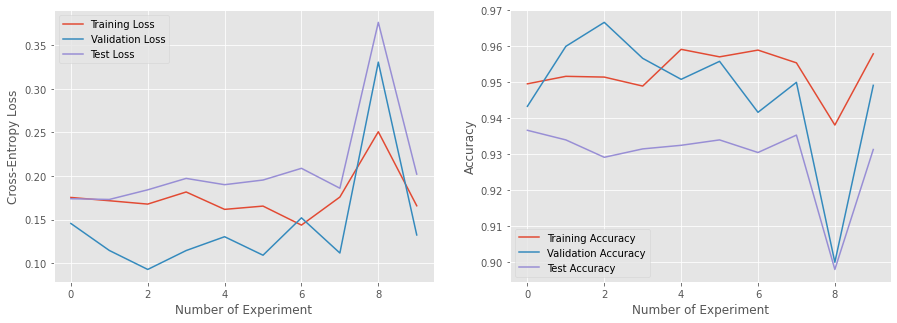

In [116]:
plt.subplots(figsize=(15,5))

plt.subplot(121)
plt.plot(train_loss,label='Training Loss')
plt.plot(val_loss,label='Validation Loss')
plt.plot(test_loss,label='Test Loss')
plt.xlabel('Number of Experiment')
plt.ylabel('Cross-Entropy Loss')
plt.legend()

plt.subplot(122)
plt.plot(train_acc,label='Training Accuracy')
plt.plot(val_acc,label='Validation Accuracy')
plt.plot(test_acc,label='Test Accuracy')
plt.xlabel('Number of Experiment')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [86]:
f = pd.get_dummies(features)

model = Sequential()

model.add(Dense(15, activation='relu')) # len(x_wd.T)
model.add(Dropout(0.01))
model.add(Dense(2, activation='softmax'))
model.add(Dropout(0.01))
opt = tf.keras.optimizers.Adam(learning_rate=0.002) #5e-4

x_train, x_test, y_train, y_test = train_test_split(x_wd,f, test_size = 0.2, shuffle=True)

x_train_tf = tf.convert_to_tensor(x_train)
x_test_tf = tf.convert_to_tensor(x_test)
y_train_tf = tf.convert_to_tensor(y_train)
y_test_tf = tf.convert_to_tensor(y_test)

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
history = model.fit(x_train_tf, y_train_tf,validation_data=(x_test_tf,y_test_tf), epochs=400, batch_size=50)

Epoch 1/400
96/96 [==============================] - 2s 14ms/step - loss: 0.8180 - accuracy: 0.5699 - val_loss: 0.4943 - val_accuracy: 0.7767
Epoch 2/400
96/96 [==============================] - 0s 3ms/step - loss: 0.5220 - accuracy: 0.8124 - val_loss: 0.4125 - val_accuracy: 0.8192
Epoch 3/400
96/96 [==============================] - 0s 3ms/step - loss: 0.4746 - accuracy: 0.8367 - val_loss: 0.3731 - val_accuracy: 0.8442
Epoch 4/400
96/96 [==============================] - 0s 3ms/step - loss: 0.4316 - accuracy: 0.8554 - val_loss: 0.3583 - val_accuracy: 0.8567
Epoch 5/400
96/96 [==============================] - 0s 3ms/step - loss: 0.4152 - accuracy: 0.8583 - val_loss: 0.3421 - val_accuracy: 0.8725
Epoch 6/400
96/96 [==============================] - 0s 3ms/step - loss: 0.3995 - accuracy: 0.8701 - val_loss: 0.3315 - val_accuracy: 0.8750
Epoch 7/400
96/96 [==============================] - 0s 3ms/step - loss: 0.3744 - accuracy: 0.8697 - val_loss: 0.3448 - val_accuracy: 0.8758
Epoch 8/400


Epoch 59/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2627 - accuracy: 0.9125 - val_loss: 0.1759 - val_accuracy: 0.9308
Epoch 60/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2264 - accuracy: 0.9294 - val_loss: 0.1703 - val_accuracy: 0.9342
Epoch 61/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2412 - accuracy: 0.9314 - val_loss: 0.1713 - val_accuracy: 0.9308
Epoch 62/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2201 - accuracy: 0.9335 - val_loss: 0.1668 - val_accuracy: 0.9300
Epoch 63/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2414 - accuracy: 0.9239 - val_loss: 0.3569 - val_accuracy: 0.8600
Epoch 64/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2659 - accuracy: 0.9157 - val_loss: 0.1704 - val_accuracy: 0.9317
Epoch 65/400
96/96 [==============================] - 0s 5ms/step - loss: 0.1947 - accuracy: 0.9348 - val_loss: 0.1662 - val_accuracy: 0.9358
Epoch 

96/96 [==============================] - 0s 3ms/step - loss: 0.2080 - accuracy: 0.9340 - val_loss: 0.1453 - val_accuracy: 0.9392
Epoch 174/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1953 - accuracy: 0.9407 - val_loss: 0.1507 - val_accuracy: 0.9392
Epoch 175/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1990 - accuracy: 0.9408 - val_loss: 0.1506 - val_accuracy: 0.9342
Epoch 176/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2278 - accuracy: 0.9382 - val_loss: 0.1497 - val_accuracy: 0.9383
Epoch 177/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1697 - accuracy: 0.9464 - val_loss: 0.1488 - val_accuracy: 0.9400
Epoch 178/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1980 - accuracy: 0.9408 - val_loss: 0.1470 - val_accuracy: 0.9408
Epoch 179/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2085 - accuracy: 0.9428 - val_loss: 0.1445 - val_accuracy: 0.9433
Epoch 180/400

96/96 [==============================] - 0s 3ms/step - loss: 0.1803 - accuracy: 0.9491 - val_loss: 0.1410 - val_accuracy: 0.9400
Epoch 288/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1836 - accuracy: 0.9483 - val_loss: 0.1443 - val_accuracy: 0.9417
Epoch 289/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1684 - accuracy: 0.9481 - val_loss: 0.1464 - val_accuracy: 0.9417
Epoch 290/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1787 - accuracy: 0.9492 - val_loss: 0.1446 - val_accuracy: 0.9342
Epoch 291/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1885 - accuracy: 0.9442 - val_loss: 0.1498 - val_accuracy: 0.9392
Epoch 292/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1793 - accuracy: 0.9426 - val_loss: 0.1440 - val_accuracy: 0.9433
Epoch 293/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1980 - accuracy: 0.9426 - val_loss: 0.1442 - val_accuracy: 0.9400
Epoch 294/400

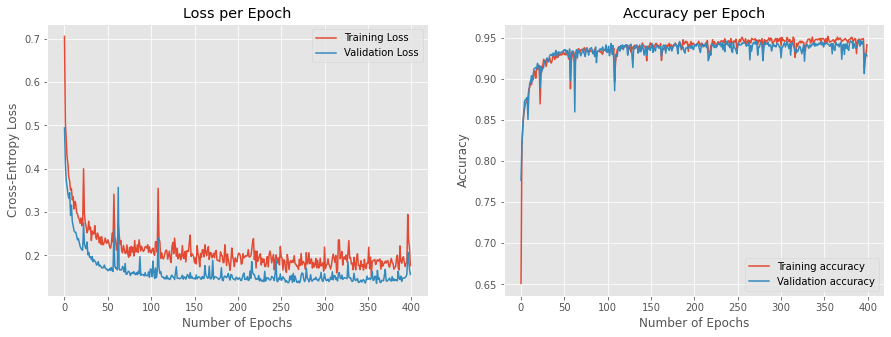

In [87]:
plt.subplots(figsize=(15,5))

plt.subplot(121)
plt.plot(history.history['loss'],label = 'Training Loss')
plt.plot(history.history['val_loss'],label = 'Validation Loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.title('Loss per Epoch')
plt.legend()

plt.subplot(122)
plt.plot(history.history['accuracy'],label = 'Training accuracy')
plt.plot(history.history['val_accuracy'],label = 'Validation accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()

plt.show()

In [88]:
yy_test = pd.get_dummies(yy)
results = model.evaluate(xx_dummy, yy_test, batch_size=128)
#y_hat = model.predict_classes(xx_dummy, verbose=1)
#y_hat_dummy = pd.get_dummies(y_hat)
print("test loss, test acc:", results)
#print(sklearn.metrics.f1_score(y_hat_dummy, yy_test,average='micro'))

47/47 [==============================] - 0s 4ms/step - loss: 0.1708 - accuracy: 0.9293
test loss, test acc: [0.1707879602909088, 0.9293333292007446]


In [89]:
results[0]

0.1707879602909088

In [90]:
svm_y = np.empty((len(features),1))

for i in range(len(features)):
    if features.iloc[i] == 1:
        svm_y[i] = 1
    else:
        svm_y[i] = -1

svm_y.astype(int)
x_train, x_test, y_train, y_test = train_test_split(x_wd,svm_y, test_size = 0.2, shuffle=True)


clf = svm.SVC(kernel='rbf')
clf.fit(x_train, y_train)
print('Training Accuracy: ',clf.score(x_train, y_train))
print('Validation Accuracy: ',clf.score(x_test, y_test))

/usr/local/Caskroom/miniconda/base/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.945
0.9316666666666666


In [91]:
svm_y_test = np.empty((len(yy),1))

for i in range(len(yy)):
    if yy.iloc[i] == 1:
        svm_y_test[i] = 1
    else:
        svm_y_test[i] = -1

In [92]:
y_pred = clf.predict(xx_dummy)
print('Test Accuracy: ',clf.score(xx_dummy, svm_y_test))
print(sklearn.metrics.f1_score(y_pred, svm_y_test,average='micro'))

0.926
0.926


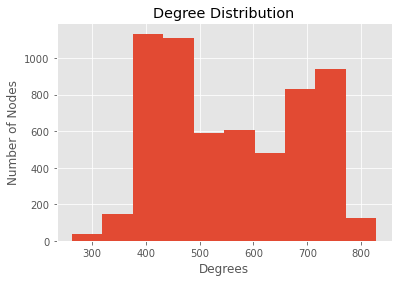

In [93]:
def plot_degree_dist(G):
    degrees = [G.degree(n) for n in G.nodes()]
    plt.hist(degrees)
    plt.title('Degree Distribution')
    plt.xlabel('Degrees')
    plt.ylabel('Number of Nodes')
    plt.show()
    
plot_degree_dist(G)

In [94]:
G.number_of_edges()

1678903

In [95]:
clf = RandomForestClassifier(max_depth=None, random_state=0)

x_train, x_test, y_train, y_test = train_test_split(x_wd,svm_y, test_size = 0.2, shuffle=True)

clf.fit(x_train, y_train)
print('Training Accuracy: ',clf.score(x_train, y_train))
print('Validation Accuracy: ',clf.score(x_test, y_test))

<ipython-input-95-ecdc1502b742>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train, y_train)


1.0
0.9525


In [96]:
y_pred = clf.predict(xx_dummy)
print('Test Accuracy: ',clf.score(xx_dummy, svm_y_test))
print(sklearn.metrics.f1_score(y_pred, svm_y_test))

0.9473333333333334
0.9385930820054412


In [97]:
clf = AdaBoostClassifier(n_estimators=100, random_state=0)
clf.fit(x_train, y_train)
y_pred = clf.predict(xx_dummy)
print('Training Accuracy: ',clf.score(x_train, y_train))
print('Validation Accuracy: ',clf.score(x_test, y_test))
print('Test Accuracy: ',clf.score(xx_dummy, yy))
print(sklearn.metrics.f1_score(y_pred, svm_y_test))

/usr/local/Caskroom/miniconda/base/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.9347916666666667
0.93
0.9215
0.9083122445006813


In [98]:
clf = GaussianNB()
clf.fit(x_train, y_train)
y_pred = clf.predict(xx_dummy)
print('Training Accuracy: ',clf.score(x_train, y_train))
print('Validation Accuracy: ',clf.score(x_test, y_test))
print('Test Accuracy: ',clf.score(xx_dummy, yy))
print(sklearn.metrics.f1_score(y_pred, svm_y_test))

0.8704166666666666
0.8741666666666666
0.8613333333333333
0.8395061728395061


/usr/local/Caskroom/miniconda/base/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [99]:
clf = QDA()
clf.fit(x_train, y_train)
print('Training Accuracy: ',clf.score(x_train, y_train))
print('Validation Accuracy: ',clf.score(x_test, y_test))
print('Test Accuracy: ',clf.score(xx_dummy, yy))

0.7264583333333333
0.7066666666666667
0.7215


/usr/local/Caskroom/miniconda/base/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/usr/local/Caskroom/miniconda/base/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [100]:
x_train, x_test, y_train, y_test = train_test_split(x_wd,features, test_size = 0.2, shuffle=True)
clf = LogisticRegression(random_state=0,max_iter=500).fit(x_train, y_train)
y_pred = clf.predict(xx_dummy)
print('Training Accuracy: ',clf.score(x_train, y_train))
print('Validation Accuracy: ',clf.score(x_test, y_test))
print('Test Accuracy: ',clf.score(xx_dummy, yy))
print(sklearn.metrics.f1_score(y_pred, yy))

0.8795833333333334
0.8775
0.8666666666666667
0.8434442270058707
